In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightkurve as lk
from astropy.timeseries import LombScargle
from scipy.signal import find_peaks, peak_widths, peak_prominences, medfilt, savgol_filter
from mesagrid import Track
import mesa_reader as mr
# import pygyre as pg
import os
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy import units as u
from scipy.ndimage import median_filter, uniform_filter1d
from itertools import combinations
%matplotlib inline

In [2]:
%config InlineBackend.figure_format='retina'
plt.rcParams.update({
    'axes.linewidth' : 1,
    'ytick.major.width' : 1,
    'ytick.minor.width' : 1,
    'xtick.major.width' : 1,
    'xtick.minor.width' : 1,
    'xtick.labelsize': 10, 
    'ytick.labelsize': 10,
    'axes.labelsize': 12,
    'font.family': 'serif',
    'text.usetex': False
})

We are trying to do similar analysis like [KIC 4552982: OUTBURSTS AND ASTEROSEISMOLOGY FROM THE LONGEST PSEUDO-CONTINUOUS LIGHT CURVE OF A ZZ Ceti](https://iopscience.iop.org/article/10.1088/0004-637X/809/1/14#apj516870t2):

In [3]:
ID = 'KIC 4552982'

In [4]:
lk = lk.search_lightcurve(f'{ID}', mission = 'Kepler', quarter=14)
lk

SearchResult containing 4 data products.

 #       mission      year author exptime  target_name  distance
                                     s                   arcsec 
--- ----------------- ---- ------ ------- ------------- --------
  0 Kepler Quarter 14 2012 Kepler      60 kplr004552982      0.0
  1 Kepler Quarter 14 2012 Kepler      60 kplr004552982      0.0
  2 Kepler Quarter 14 2012 Kepler      60 kplr004552982      0.0
  3 Kepler Quarter 14 2012 Kepler    1800 kplr004552982      0.0

In [5]:
lc = lk.download_all().stitch()
lc

<KeplerLightCurve length=135367 LABEL="KIC 4552982" QUARTER=14 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
       time             flux      ...   pos_corr1      pos_corr2   
                                  ...      pix            pix      
       Time           float32     ...    float32        float32    
------------------ -------------- ... -------------- --------------
1274.1303406126463            ——— ...  2.8477326e-02  3.1032607e-02
1274.1310217352293  1.0104601e+00 ...  2.8488761e-02  3.1032277e-02
1274.1317027578189  1.0341710e+00 ...  2.8500192e-02  3.1031946e-02
1274.1323839804027  9.9356669e-01 ...  2.8511629e-02  3.1031616e-02
1274.1330651029857  9.8337257e-01 ...  2.8523061e-02  3.1031286e-02
1274.1337462255688  9.8669481e-01 ...  2.8534496e-02  3.1030955e-02
1274.1344274481526  9.9749058e-01 ...  2.8545931e-02  3.1030625e-02
1274.1351085705028  9.8416764e-01 ...  2.8557364e-02  3.1030294e-02
 1274.135789693093  9.8096514e-01 ...  2.8568799e-02  3.1029964e-02
               ...            ... ...            ...            ...
1371.1589463695054  1.0030378e+00 ... -1.1601185e-01 -1.0265076e-01
1371.1793793658944  9.9295861e-01 ... -1.1600603e-01 -1.0283232e-01
 1371.199812162282  9.9749285e-01 ... -1.1617936e-01 -1.0298013e-01
1371.2202450581972  9.9868381e-01 ... -1.1599079e-01 -1.0276809e-01
1371.2406779541197  9.9741101e-01 ... -1.1633186e-01 -1.0302038e-01
1371.2611108495767  9.9517256e-01 ... -1.1628750e-01 -1.0313687e-01
   1371.2815436448  9.9879754e-01 ... -1.1652970e-01 -1.0328604e-01
1371.3019766400175  1.0054027e+00 ... -1.1644558e-01 -1.0307874e-01
 1371.322409534776  1.0121940e+00 ... -1.1623753e-01 -1.0301646e-01

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

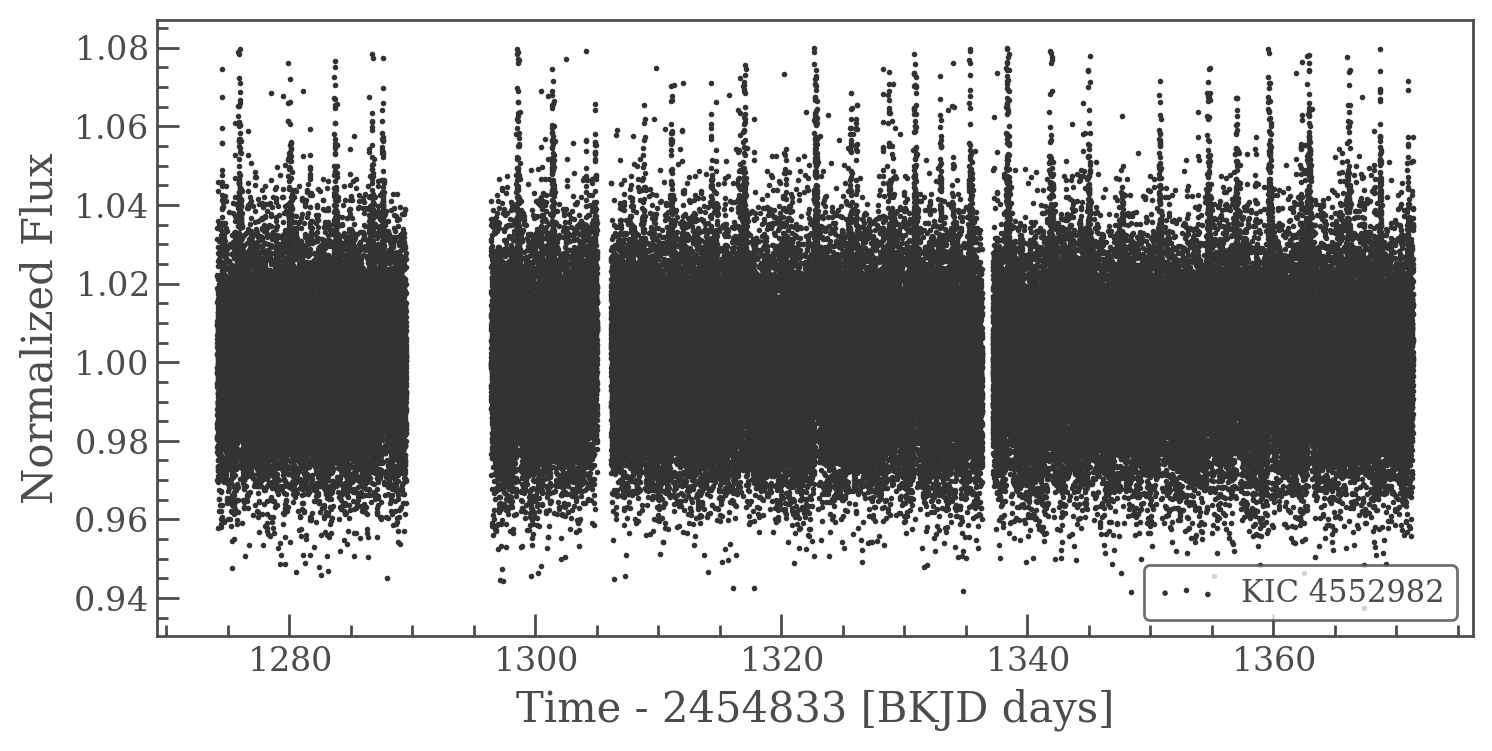

In [6]:
lc = lc.remove_outliers()
lc.scatter()

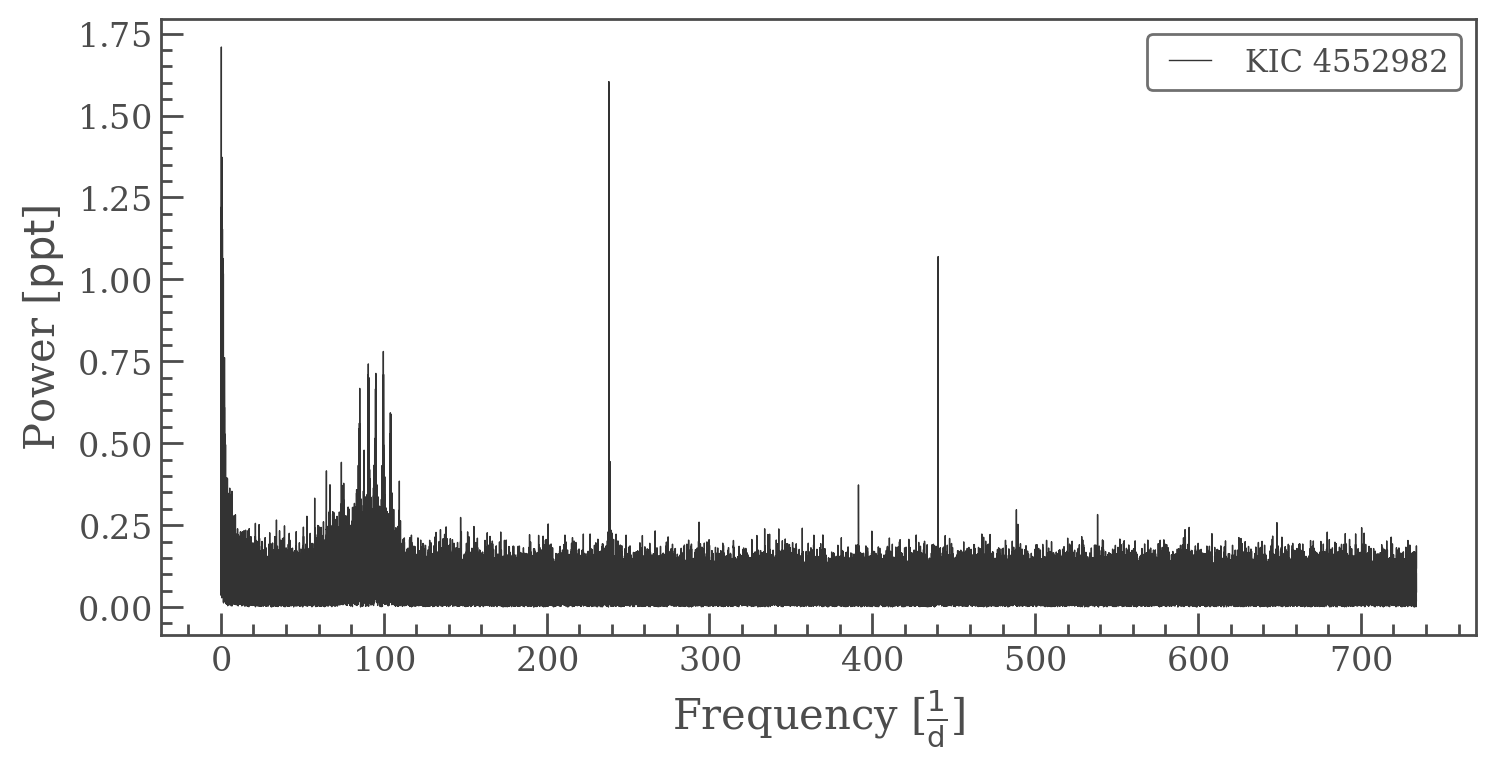

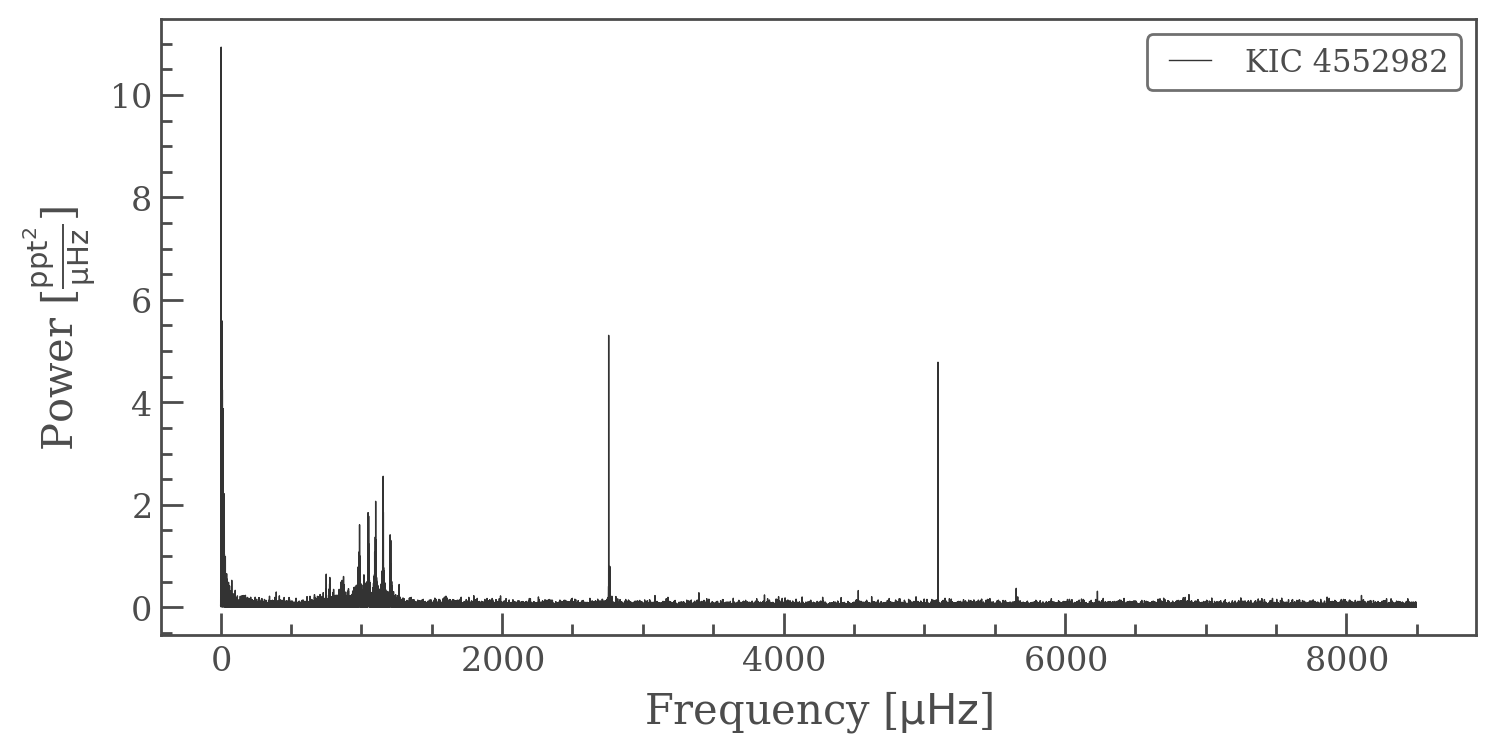

In [7]:
pg = lc.normalize(unit = 'ppt').to_periodogram()#normalization = 'psd')
pg.plot();
pg = lc.normalize(unit = 'ppt').to_periodogram(normalization = 'psd')
pg.plot();
# pg = lc.normalize(unit = 'ppt')

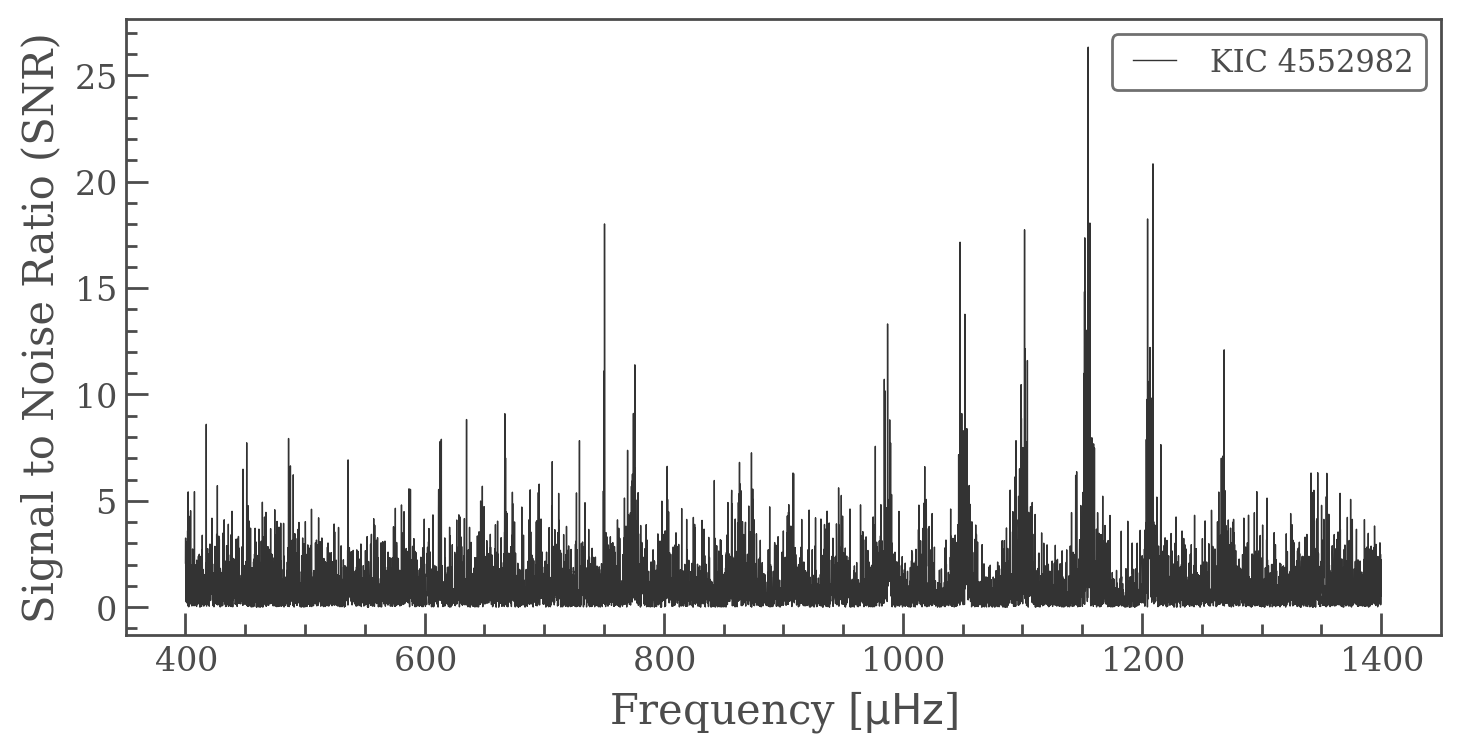

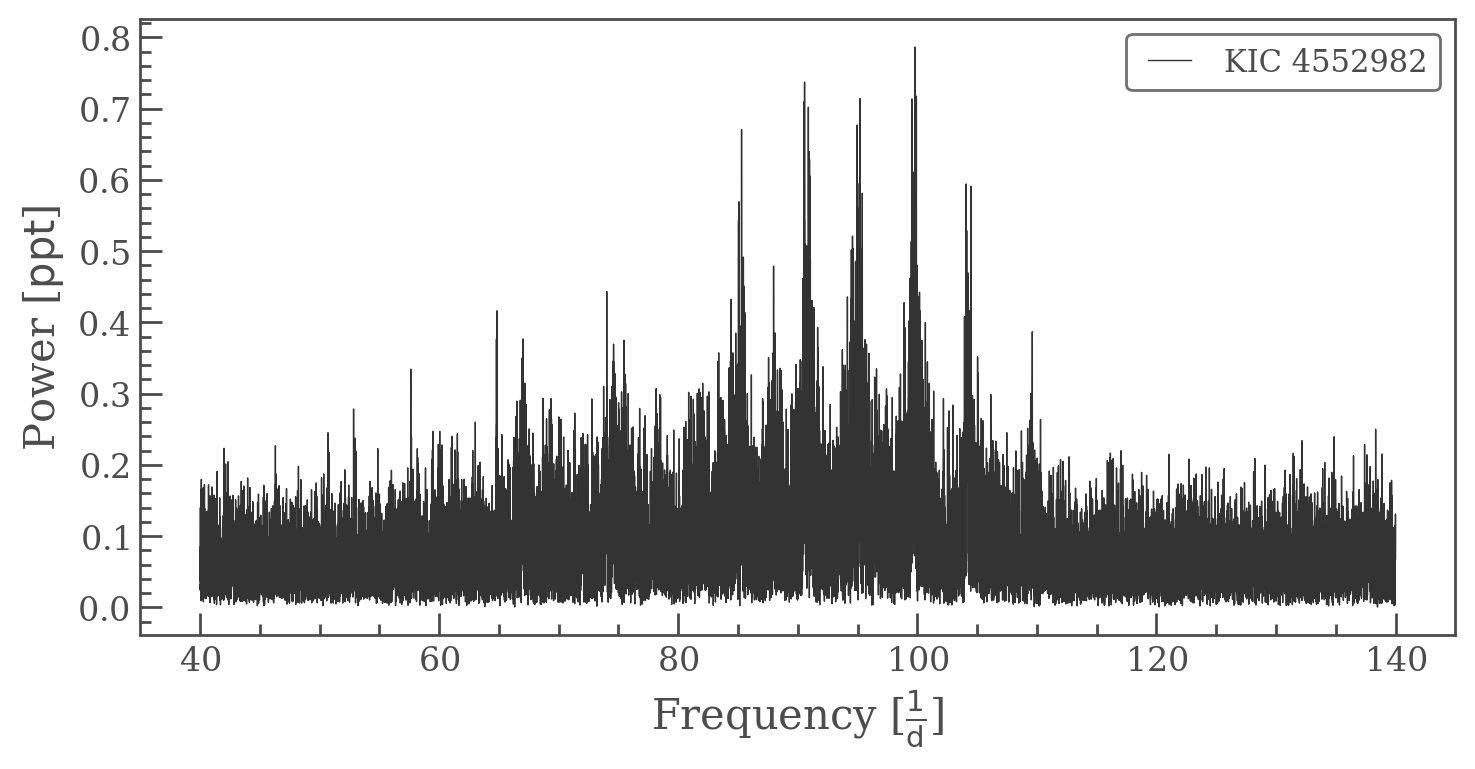

In [8]:
zoom_pg = lc.normalize(unit = 'ppt').to_periodogram(normalization = 'psd', 
                                                    minimum_frequency = 400, 
                                                    maximum_frequency = 1400).flatten()
zoom_pg.plot()
zoom_pg = lc.normalize(unit = 'ppt').to_periodogram(minimum_frequency = 40, 
                                                    maximum_frequency = 140)#.flatten()
zoom_pg.plot();

In [9]:
seismology = zoom_pg.to_seismology()

/Users/surendrabhattarai/anaconda3/envs/juliet-env/lib/python3.11/site-packages/lightkurve/seismology/core.py:77: LightkurveWarning: Seismology received a periodogram which does not appear to have been background-corrected. Please consider calling `periodogram.flatten()` prior to extracting seismological parameters.
  warnings.warn(


In [10]:
seismology.estimate_numax()

numax: 97.46 1 / d (method: ACF2D)

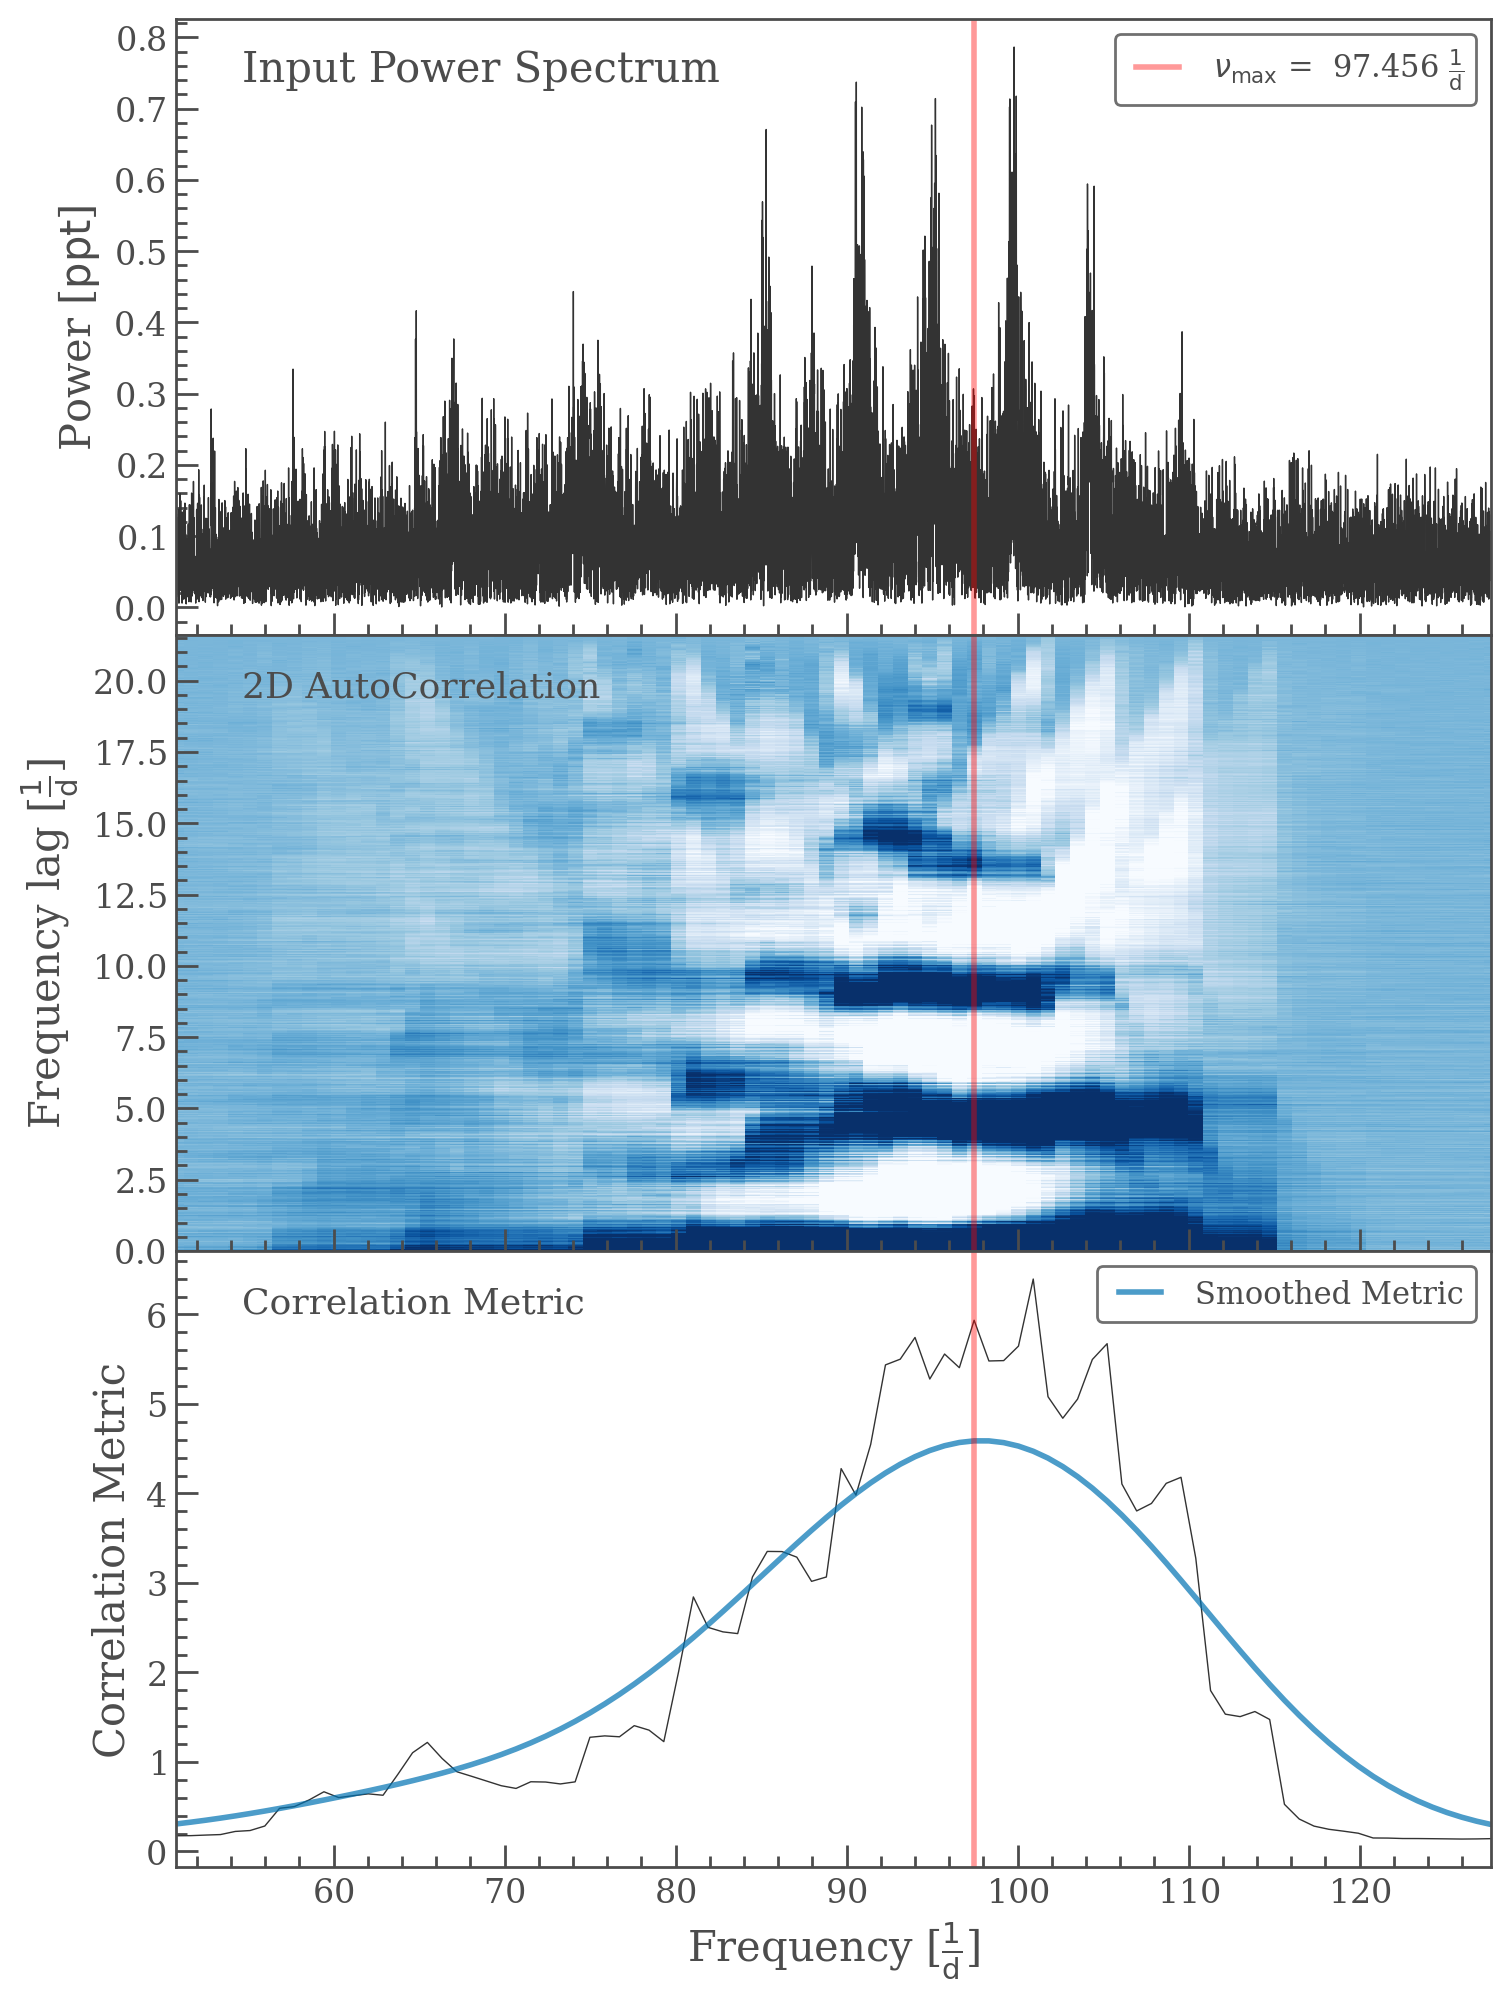

In [11]:
seismology.diagnose_numax();

In [12]:
seismology.estimate_deltanu()

deltanu: 4.56 1 / d (method: ACF2D)

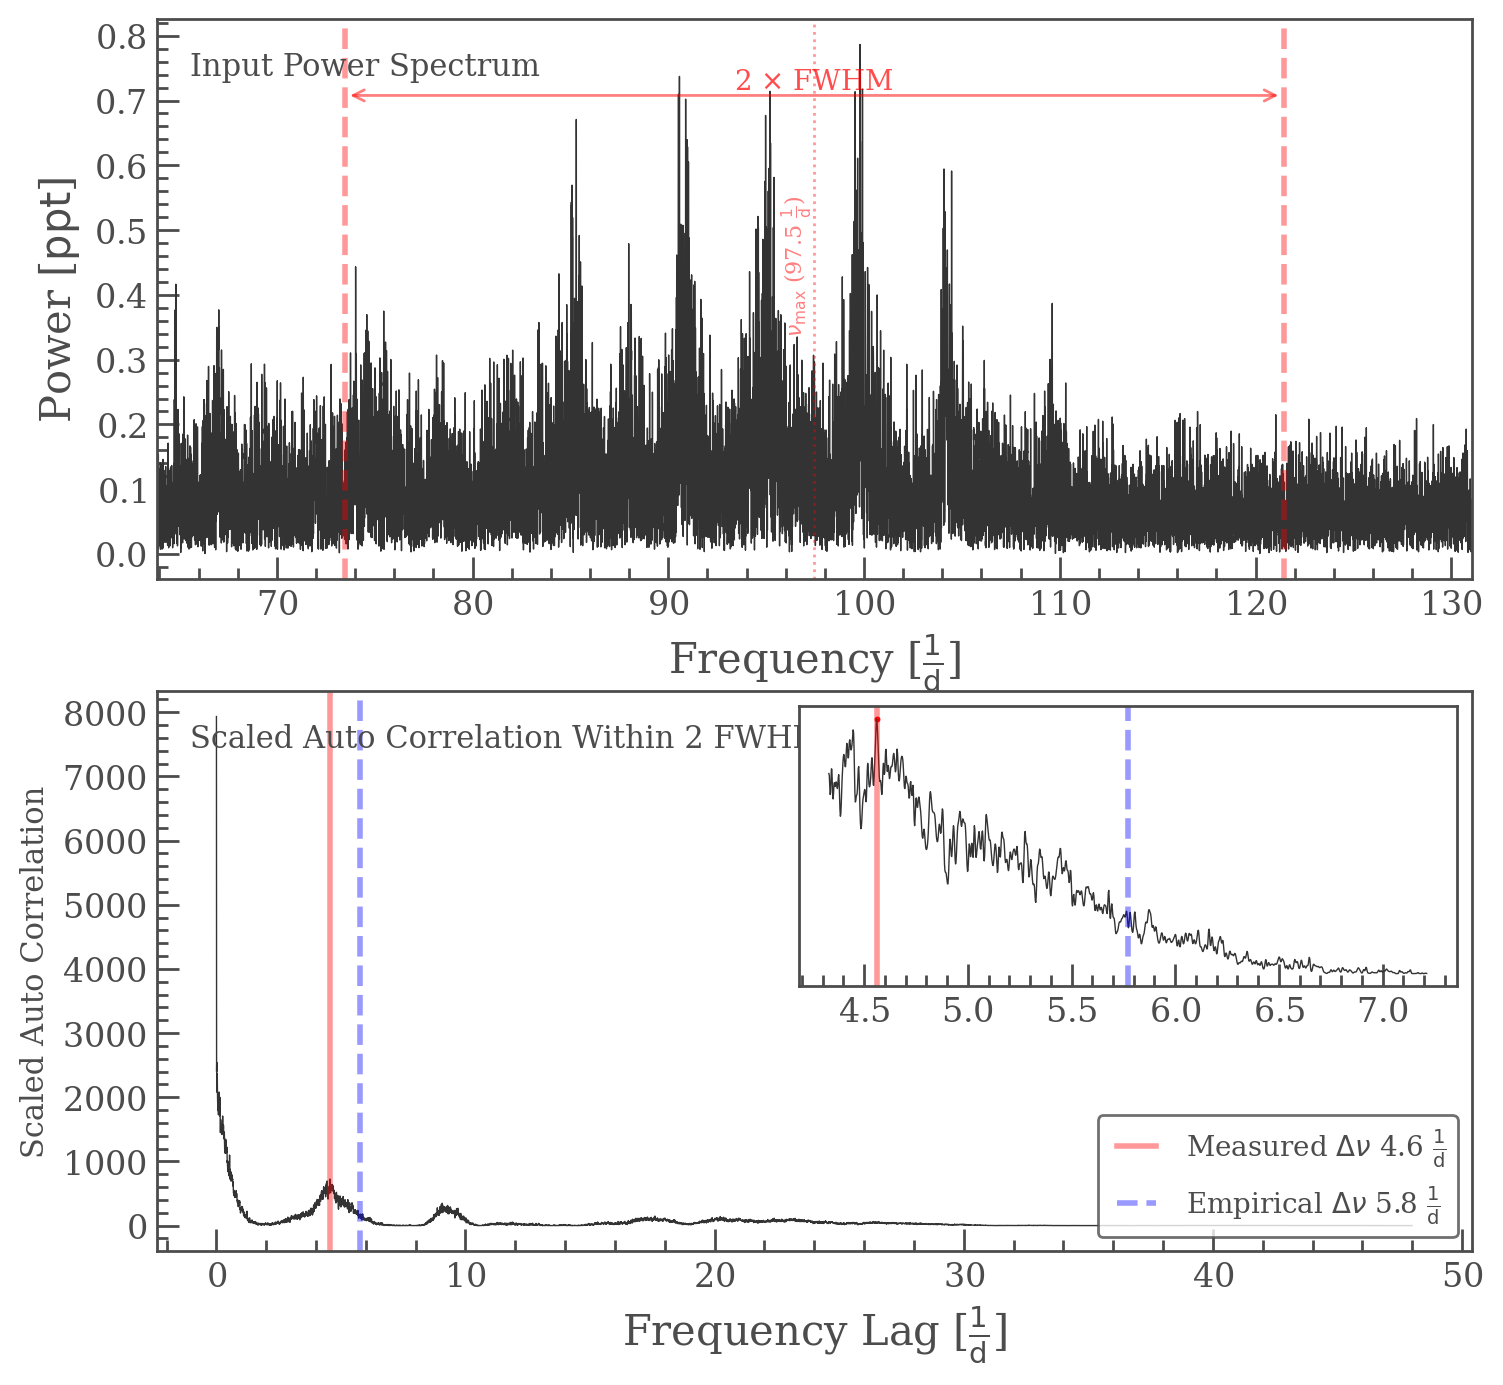

In [13]:
seismology.diagnose_deltanu();

In [14]:
# seismology.estimate_mass()

In [15]:
# seismology.estimate_radius()

In [16]:
# seismology.estimate_logg()

In [17]:
seismology

Seismology(ID: KIC 4552982) - computed values:
 * numax: 97.46 1 / d (method: ACF2D)
 * deltanu: 4.56 1 / d (method: ACF2D)

nu0_uHz   HWHM_uHz  Height_ppt2
0    775.226919   2.871873     0.128175
1    855.702505   0.766318     0.054765
2    865.425063  11.420597     0.097083
3    907.411509   3.327365     0.053052
4    986.280000   5.054374     0.286794
5   1018.173181   3.210794     0.112822
6   1050.925198   4.840220     0.456824
7   1100.308382   5.798886     0.375842
8   1154.693224   3.455567     0.594766
9   1206.205858   2.988618     0.331327
10  1268.278131   2.545415     0.066331

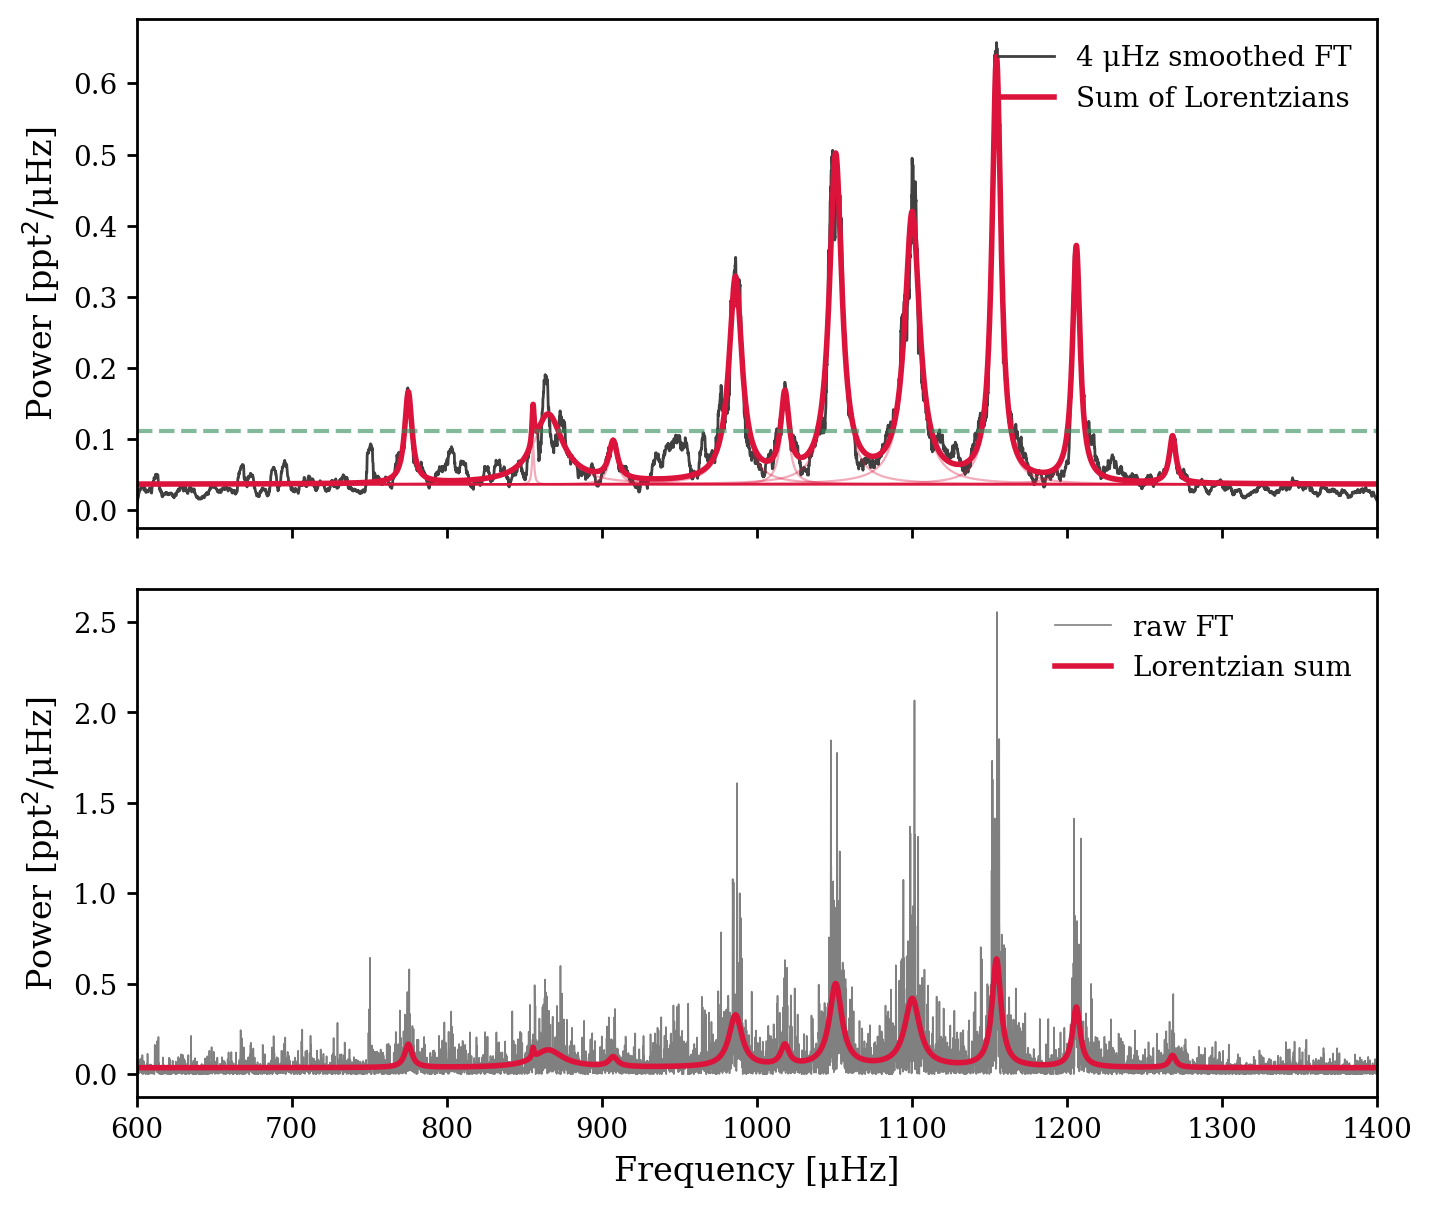

In [18]:
f = pg.frequency.to(u.uHz).value
P = pg.power.value
band = (f >= 600) & (f <= 1400)
f, P = f[band].astype(float), P[band].astype(float)


df = np.median(np.diff(f))

def smooth_boxcar(y, width_uHz):
    w = max(3, int(round(width_uHz/df)))
    k = np.ones(w) / w
    return np.convolve(y, k, mode="same")

P_s = smooth_boxcar(P, 4.0)  # 4 μHz boxcar (for peak finding only)


def lorentzian(fr, H, nu0, gamma):

    return H / (1.0 + ((fr - nu0) / gamma) ** 2)

def lorentz_sum(fr, C, *params):
    # params = [H1,nu1,g1, H2,nu2,g2, ...]
    tot = C * np.ones_like(fr)
    for H, nu, g in np.array(params).reshape(-1, 3):
        tot += lorentzian(fr, H, nu, g)
    return tot

# Seed peaks 
prom_base = np.percentile(P_s, 95)
pk, props = find_peaks(P_s,
                       prominence=0.25*prom_base,            # using prominence here, not absolute height; taking top K by prominence
                       distance=max(1, int(round(6.0/df))))  # ≥6 μHz apart
if pk.size == 0:  # fallback slightly looser
    pk, props = find_peaks(P_s, prominence=0.15*prom_base,
                           distance=max(1, int(round(5.0/df))))

Kmax = 12
order = np.argsort(props["prominences"])[::-1][:Kmax]
pk = pk[order]

seed_centers = f[pk]
# estimating widths from the smoothed peak shapes
w_res = peak_widths(P_s, pk, rel_height=0.5)[0] * df  # FWHM in μHz
seed_widths = np.clip(0.5 * w_res, 0.4, 6.0)  # HWHM initial
seed_heights = np.clip(P_s[pk] - np.median(P_s), 1e-4, None)

# Fit on the smoothed spectrum 
C0 = np.percentile(P_s, 10)
theta0 = [C0]
lo, hi = [0.0], [np.inf]
for H, nu, g in zip(seed_heights, seed_centers, seed_widths):
    theta0 += [H, nu, g]
    lo     += [0.0, nu - 4.0, 0.2]    
    hi     += [np.inf, nu + 4.0, 12.0]

popt, pcov = curve_fit(lorentz_sum, f, P_s, p0=theta0,
                       bounds=(lo, hi), maxfev=200000)


Cfit = popt[0]
pars  = np.array(popt[1:]).reshape(-1, 3)
fit_tab = pd.DataFrame(
    dict(nu0_uHz=pars[:,1], HWHM_uHz=pars[:,2], Height_ppt2=pars[:,0])
).sort_values("nu0_uHz").reset_index(drop=True)
display(fit_tab.head(20))


fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(8, 7), sharex=True,
                                     gridspec_kw=dict(hspace=0.12))

# smoothed FT + model + components
ax_top.plot(f, P_s, color="0.25", lw=1.0, label="4 μHz smoothed FT")
ax_top.plot(f, lorentz_sum(f, *popt), color="crimson", lw=2.0, label="Sum of Lorentzians")


for H, nu, g in pars:
    ax_top.plot(f, Cfit + lorentzian(f, H, nu, g), color="crimson", lw=0.8, alpha=0.35)

# a simple significance proxy (green dashed)
quiet = (f < 700) | (f > 1350)
sig = 4.0 * np.median(P_s[quiet])
ax_top.axhline(sig, ls="--", color="seagreen", alpha=0.6)

ax_top.set_ylabel("Power [ppt$^2$/μHz]")
ax_top.set_xlim(600, 1400)
ax_top.legend(frameon=False, loc="upper right")

# raw FT with the same fitted sum drawn over it
ax_bot.plot(f, P, color="0.5", lw=0.6, label="raw FT")
ax_bot.plot(f, lorentz_sum(f, *popt), color="crimson", lw=2.0, label="Lorentzian sum")
ax_bot.set_xlabel("Frequency [μHz]")
ax_bot.set_ylabel("Power [ppt$^2$/μHz]")
ax_bot.legend(frameon=False, loc="upper right")
plt.show()

In [19]:
assert ('f' in globals()) and ('P' in globals())

# Converting x-axis to period (seconds) 
Psec = 1e6 / f               # P = 1/f; f in µHz → P in s
order = np.argsort(Psec)     # growing period
Psec  = Psec[order]
Ppow  = P[order]

# Uniform period grid (paper said: ~667–2000 s lives inside 600–1500 µHz)
Pmin, Pmax, dP = 700.0, 1700.0, 0.5   # step ~0.5 s is fine
Pgrid = np.arange(Pmin, Pmax + dP/2, dP)
Ygrid = np.interp(Pgrid, Psec, Ppow)  # FT re-sampled in (period, power)

**Period transform of the period transform → peak at ΔP**

We look for a periodicity in the period domain, i.e., regular spacing. A robust way is to FFT the period-domain curve and convert FFT frequency to a spacing in seconds, then pick the biggest peak in a sensible range.

In [20]:
# Detrend & window to keep leakage in check
y = Ygrid - np.median(Ygrid)
w = np.hanning(y.size)
yw = y * w

# FFT in the period domain (independent variable is 'period' with step dP)
F = np.fft.rfft(yw)
nu_prime = np.fft.rfftfreq(yw.size, d=dP)     # cycles per second-of-period
power_PT = (F.real**2 + F.imag**2)

with np.errstate(divide='ignore'):
    spacing_s = 1.0 / nu_prime
mask = (spacing_s >= 10.0) & (spacing_s <= 100.0)  # DAVs: ~15–60 s typically I guess!!! dont know!!!! ooofff!

                        # Finding peak near the expected ΔP (and its harmonic will appear at ~ΔP/2)
pk, props = find_peaks(power_PT[mask], prominence=np.percentile(power_PT[mask], 90)/4)
best = pk[np.argmax(power_PT[mask][pk])] if pk.size else np.argmax(power_PT[mask])
DeltaP = float(spacing_s[mask][best])

print(f"Estimated ΔP ≈ {DeltaP:.2f} s")

Estimated ΔP ≈ 47.64 s


Similar to fig. 12, 13 of [KIC 4552982: OUTBURSTS AND ASTEROSEISMOLOGY FROM THE LONGEST PSEUDO-CONTINUOUS LIGHT CURVE OF A ZZ Ceti](https://iopscience.iop.org/article/10.1088/0004-637X/809/1/14#apj516870t2):

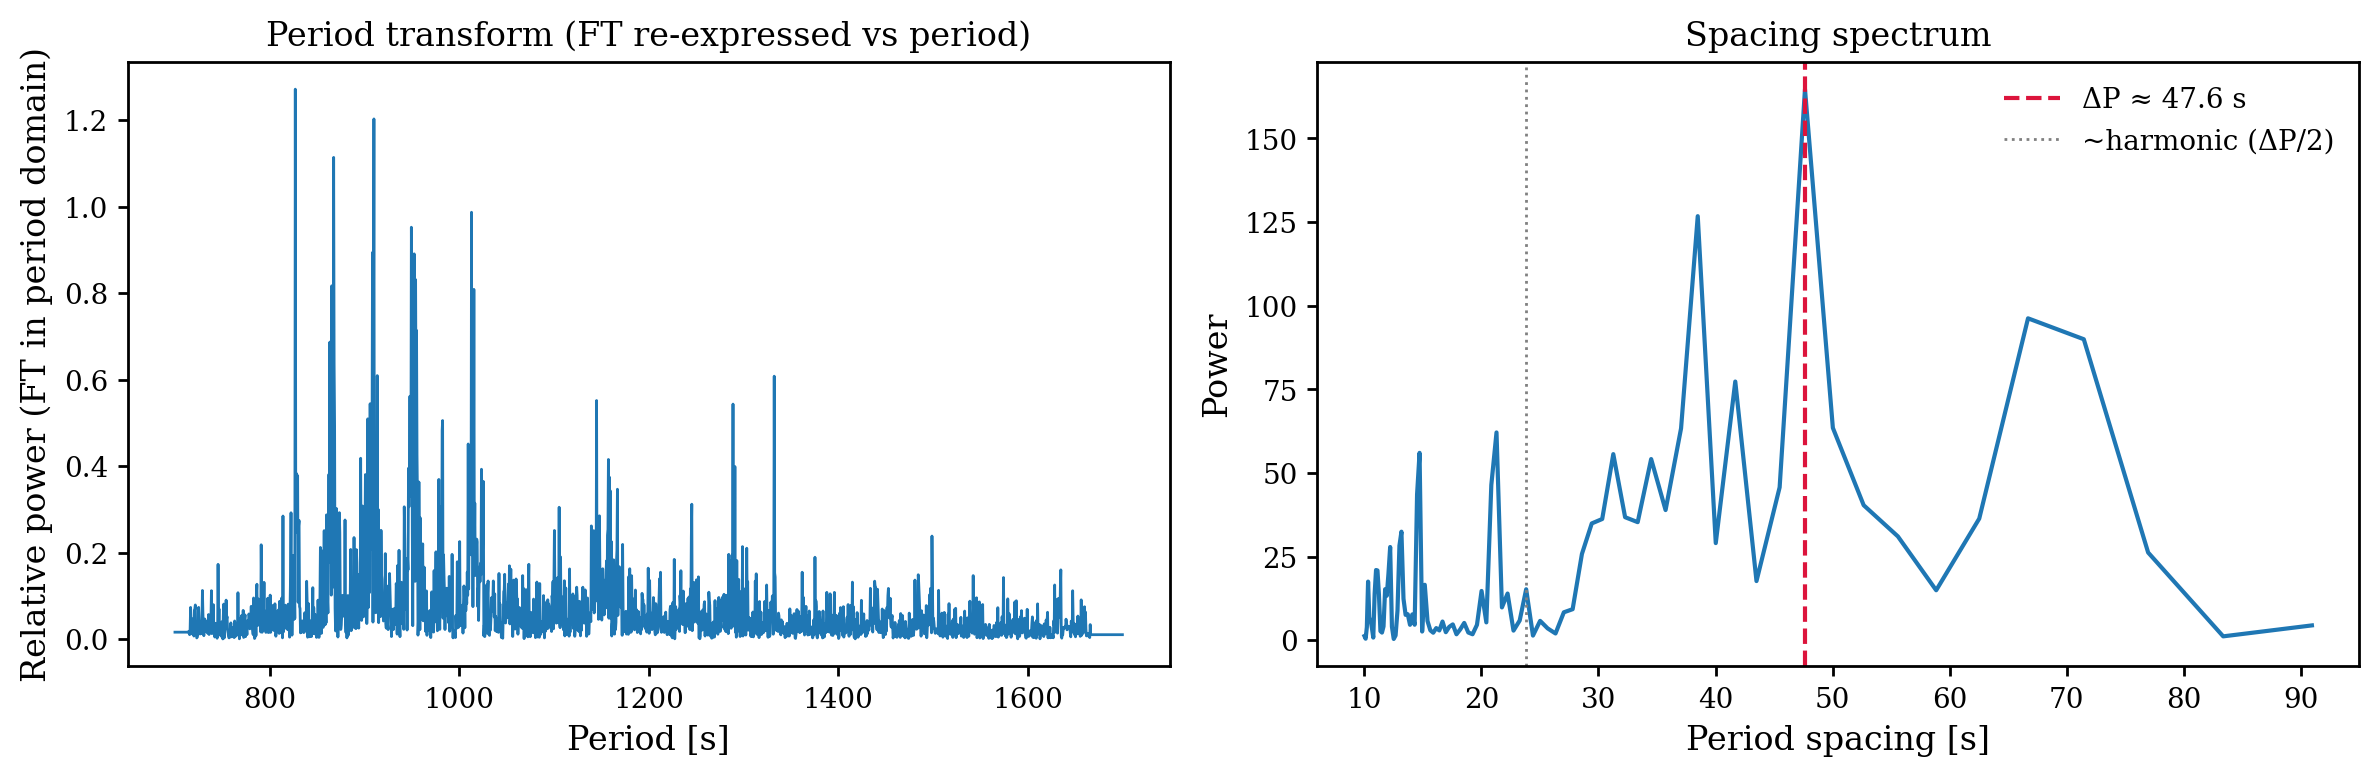

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Left: period transform (FT vs period)
ax[0].plot(Pgrid, Ygrid, color='tab:blue', lw=1)
ax[0].set_xlabel("Period [s]")
ax[0].set_ylabel("Relative power (FT in period domain)")
ax[0].set_title("Period transform (FT re-expressed vs period)")

# Right: "period transform of period transform" → peak at ΔP
ax[1].plot(spacing_s[mask], power_PT[mask], color='tab:blue')
ax[1].axvline(DeltaP, color='crimson', ls='--', lw=1.5, label=fr"ΔP ≈ {DeltaP:.1f} s")
ax[1].axvline(0.5*DeltaP, color='gray', ls=':', lw=1, label="~harmonic (ΔP/2)")
ax[1].set_xlabel("Period spacing [s]")
ax[1].set_ylabel("Power")
ax[1].set_title("Spacing spectrum")
ax[1].legend(frameon=False)
plt.tight_layout()
plt.show()


Better band + whitening in the period domain

In [22]:
f_uHz = pg.frequency.to(u.uHz).value         
Ppow  = pg.power.value   # [ppt^2/µHz]
Psec  = 1e6 / f_uHz   # period [s]

m_band = (Psec >= 700) & (Psec <= 1600)
Pgrid  = Psec[m_band]
Ygrid  = Ppow[m_band]

o = np.argsort(Pgrid)
Pgrid, Ygrid = Pgrid[o], Ygrid[o]

# whitenning by subtracting a slow baseline in period domain

dP   = np.median(np.diff(Pgrid)) # 80s running-median seems a good start, keeps peaks
w80  = max(5, 2*int(round(80.0/dP)//2)+1)     
Bper = median_filter(Ygrid, size=w80, mode="nearest")
Yw   = np.clip(Ygrid - Bper, 0, None)        

W = 520.0
starts = np.arange(Pgrid.min(), Pgrid.max()-W, 5.0)
score = []
for s in starts:
    m = (Pgrid>=s) & (Pgrid<=s+W)
    score.append(Yw[m].sum())
P_lo = starts[int(np.argmax(score))]
P_hi = P_lo + W
m_tight = (Pgrid>=P_lo) & (Pgrid<=P_hi)
P_use, Y_use = Pgrid[m_tight], Yw[m_tight]

print(f"Using period window: {P_lo:.0f}–{P_hi:.0f} s  (ΔP grid step ≈ {np.median(np.diff(P_use)):.2f} s)")

Using period window: 780–1300 s  (ΔP grid step ≈ 0.11 s)


Suppressing obvious combination peaks before spacing analysis

In [23]:
T_days = lc.time.jd.max() - lc.time.jd.min()
rayleigh_uHz = 1e6 / (T_days*86400.0)
tol = max(rayleigh_uHz, 0.5)   # tolerance

# modest smoothing to pick stable FT peaks
df = np.median(np.diff(f_uHz))
k  = max(3, int(round(3.0/df)))
sm = np.convolve(Ppow, np.ones(k)/k, mode="same")

m_ft = (f_uHz>=600) & (f_uHz<=1400)
pk, prop = find_peaks(sm[m_ft], prominence=np.percentile(sm[m_ft], 97)*0.15,
                      distance=int(round(0.8/df)))
fpk = f_uHz[m_ft][pk]  

# drop harmonics (2fi) and pair sums (fi+fj)
drop = set()
for i in range(len(fpk)):
    # harmonics
    h  = 2.0*fpk[i]
    kH = np.where(np.abs(fpk - h) < tol)[0]
    drop.update(kH.tolist())
    # pair sums
    for j in range(i+1, len(fpk)):
        s  = fpk[i] + fpk[j]
        kS = np.where(np.abs(fpk - s) < tol)[0]
        drop.update(kS.tolist())

keep_idx   = [i for i in range(len(fpk)) if i not in drop]
f_indep    = np.sort(fpk[keep_idx])
P_indep    = 1e6 / f_indep                          # periods [s]
P_indep    = P_indep[(P_indep>=P_lo) & (P_indep<=P_hi)]

print(f"Kept {len(P_indep)} independent periods after combo cull (tol={tol:.2f} µHz).")

Kept 26 independent periods after combo cull (tol=0.50 µHz).


ΔP with an uncertainty (quick bootstrap)

In [24]:
def spacing_spectrum_phaseopt(P, dP_grid, phase_bins=61, sigma_hit=2.0):
    """
    Comb score with phase optimization.
    For each trial spacing dP, maximize score over phase φ ∈ [0,dP).   
    Score = sum exp(-(distance_to_nearest_tooth / sigma_hit)^2).
    Returns: scores (phase-optimized), best_dP, best_phase.
    """
    P = np.asarray(P, float)
    Pmin, Pmax = P.min(), P.max()
    scores = np.empty_like(dP_grid, dtype=float)
    best_phases = np.empty_like(dP_grid, dtype=float)

    for j, dP in enumerate(dP_grid):
        # trying multiple phases across [0, dP)
        phases = np.linspace(0, dP, phase_bins, endpoint=False)
        best_s, best_phi = -np.inf, 0.0
        for phi in phases:
            # tooth centers in [Pmin, Pmax]
            kmin = int(np.floor((Pmin - phi)/dP)) - 1
            kmax = int(np.ceil((Pmax - phi)/dP)) + 1
            teeth = phi + dP * np.arange(kmin, kmax+1)
            mask  = (teeth >= Pmin) & (teeth <= Pmax)
            teeth = teeth[mask]
            # distance of each P to nearest tooth
            d = np.min(np.abs(P[:, None] - teeth[None, :]), axis=1)
            s = np.exp(-(d / sigma_hit)**2).sum()
            if s > best_s:
                best_s, best_phi = s, phi
        scores[j] = best_s
        best_phases[j] = best_phi

    j_best = int(np.argmax(scores))
    return scores, float(dP_grid[j_best]), float(best_phases[j_best])


dP_grid = np.linspace(30.0, 55.0, 301)     # aiming at ℓ=1
S, dP_best, phi_best = spacing_spectrum_phaseopt(P_indep, dP_grid, phase_bins=81, sigma_hit=2.0)


def promote_if_subharmonic(dP_best, S, dP_grid, factor=2.0, ratio=0.6):
    """If best is <30 s, check 2×dP_best; if its score is comparable, promote."""
    if dP_best < 30.0:
        dP2 = dP_best * factor
        idx2 = np.argmin(np.abs(dP_grid - dP2))
        if S[idx2] >= ratio * S[np.argmax(S)]:
            return dP2
    return dP_best

dP_fund = promote_if_subharmonic(dP_best, S, dP_grid)

print(f"Phase-optimized peak: ΔP_best = {dP_best:.1f} s")
print(f"Chosen ΔP (after subharmonic check): {dP_fund:.1f} s")


rng = np.random.default_rng(42)
B = 400
boot = []
for _ in range(B):
    resamp = rng.choice(P_indep, size=len(P_indep), replace=True)
    S_b, dP_b, _ = spacing_spectrum_phaseopt(resamp, dP_grid, phase_bins=61, sigma_hit=2.0)
    boot.append(promote_if_subharmonic(dP_b, S_b, dP_grid))

boot = np.array(boot, float)
mu  = np.nanmedian(boot)
sig = 1.4826*np.nanmedian(np.abs(boot - mu))
print(f"ΔP = {mu:.1f} ± {sig:.1f} s  (bootstrap, N={np.isfinite(boot).sum()})")


Phase-optimized peak: ΔP_best = 41.1 s
Chosen ΔP (after subharmonic check): 41.1 s
ΔP = 41.0 ± 3.7 s  (bootstrap, N=400)


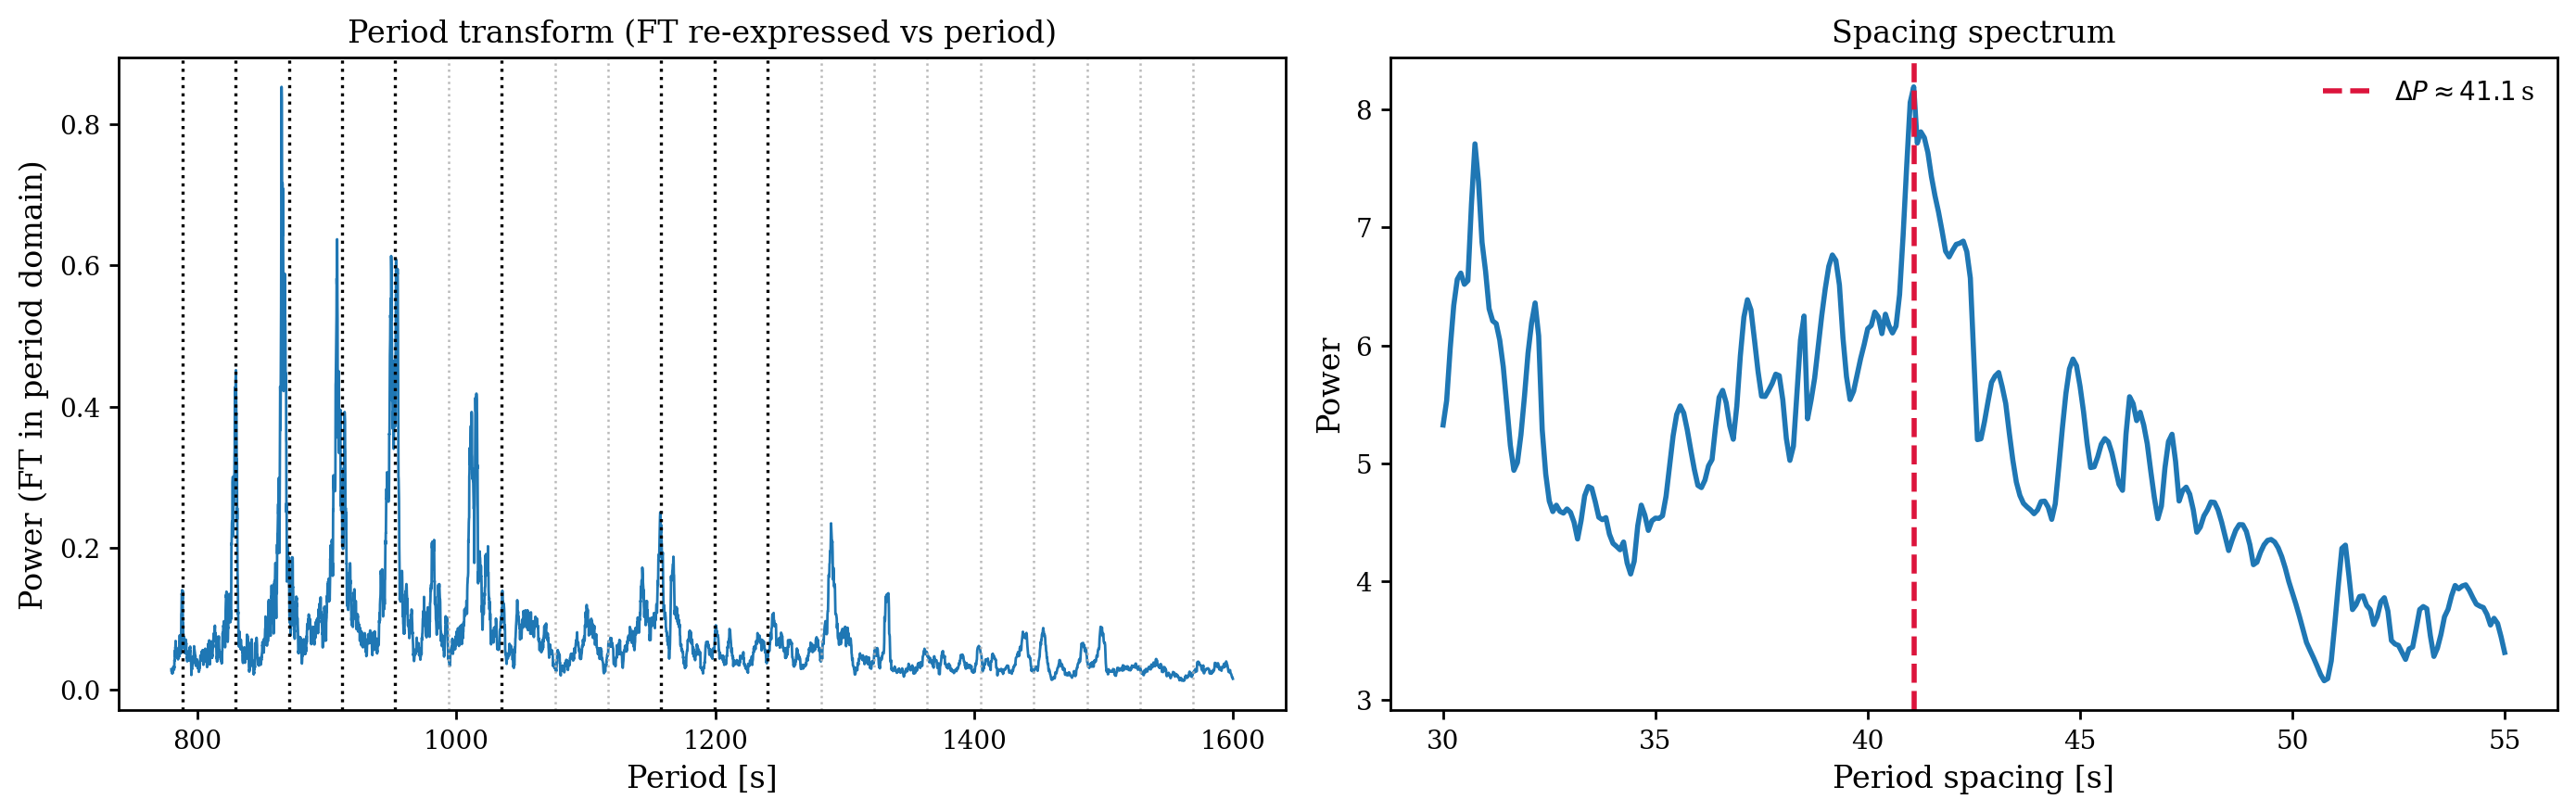

In [25]:
per = 1e6 / f   # seconds

o = np.argsort(per)
per_s = per[o]
Pow_s = P[o]
# smoothing in period (boxcar ~2 s)
dper = np.median(np.diff(per_s))
k_s  = max(3, int(round(2.0/dper)))
Pow_s_sm = uniform_filter1d(Pow_s, size=k_s)

pmin, pmax = 780.0, 1600.0
mwin = (per_s >= pmin) & (per_s <= pmax)

# Trying to build expected ℓ=1 comb lines using ΔP_fund and phase (φ)!!! confused if this is correct
def refine_phi(P, dP, pmin, pmax, weights=None):
    # Might need to refine phase φ in [pmin, pmin+dP) to best align comb with periods P.
    P = np.asarray(P, float)
    if weights is None:
        weights = np.ones_like(P)
    # restrict to plotting window
    m = (P >= pmin) & (P <= pmax)
    P = P[m]; W = np.asarray(weights, float)[m]
    if P.size == 0:
        return pmin

    phis = np.linspace(pmin, pmin + dP, 2001, endpoint=False)
    scores = np.empty_like(phis)
    for i, phi in enumerate(phis):
        k = np.rint((P - phi)/dP)
        dist = P - (phi + k*dP)
        scores[i] = np.average(np.abs(dist), weights=W)
    j = np.argmin(scores)
    return float(phis[j])

phi_ref = refine_phi(P_indep, dP_fund, pmin, pmax)

def expected_periods(dP, phi, pmin, pmax):
    phi = phi + dP * np.floor((pmin - phi)/dP + 1) 
    ks  = np.arange(-500, 500)
    Ps  = phi + ks*dP
    return Ps[(Ps >= pmin) & (Ps <= pmax)]

comb = expected_periods(dP_fund, phi_ref, pmin, pmax)

# darkening lines within ±7 s of any kept period (using the paper)   # most important way to visualize
tol_dark = 7.0
is_dark = np.zeros_like(comb, dtype=bool)
for i, Pc in enumerate(comb):
    is_dark[i] = np.min(np.abs(P_indep - Pc)) <= tol_dark

fig, (axL, axR) = plt.subplots(1, 2, figsize=(14, 4.5))

# similar to Fig. 12 
axL.plot(per_s[mwin], Pow_s_sm[mwin], color='tab:blue', lw=1.0)
for x, dark in zip(comb, is_dark):
    axL.axvline(x, color='k' if dark else '0.7',
                lw=1.2 if dark else 0.9, ls=':', alpha=1.0 if dark else 0.9)

# axL.set_xlim(pmin, pmax)
axL.set_xlabel("Period [s]")
# axL.set_ylabel("Relative power (FT in period domain)")
axL.set_ylabel("Power (FT in period domain)")
axL.set_title("Period transform (FT re-expressed vs period)")

# Similar to Fig.13-style
axR.plot(dP_grid, S, color='tab:blue', lw=2.0)
axR.axvline(dP_fund, color='crimson', ls='--', lw=2.0,
            label=fr"$\Delta P \approx {dP_fund:.1f}\,$s")
# axR.axvline(0.5*dP_fund, color='0.5', ls=':', lw=2.0,
#             label=r"~harmonic ($\Delta P/2$)")

# axR.set_xlim(dP_grid.min(), dP_grid.max())
axR.set_xlabel("Period spacing [s]")
axR.set_ylabel("Power")
axR.set_title("Spacing spectrum")
axR.legend(frameon=False, loc="upper right")

plt.tight_layout()
plt.show()

In [26]:
dP_fund

41.08333333333333

In [27]:
# def fit_phase_from_periods(P_meas, dP, Pmin, Pmax):
#     """
#     Estimate phase P0 so that P_meas ~ P0 + k*dP. Returns P0 in [Pmin,Pmin+dP).
#     """
#     P_meas = np.asarray(P_meas, float)
#     # fractional phase of each period modulo dP
#     phi = np.mod(P_meas - Pmin, dP)
#     # robust central phase
#     # map to angle to avoid wrap issues and take mean angle
#     ang = 2*np.pi*phi/dP
#     C = np.mean(np.cos(ang)); S = np.mean(np.sin(ang))
#     phi0 = (np.arctan2(S, C) % (2*np.pi)) * dP/(2*np.pi)
#     P0 = Pmin + phi0
#     # place P0 in [Pmin, Pmin + dP)
#     if P0 >= Pmin + dP: P0 -= dP
#     return P0

# def draw_l1_guides(ax, Pgrid, Ygrid, dP, P_meas=None, tol=7.0, color='k'):
#     Pmin, Pmax = float(Pgrid.min()), float(Pgrid.max())
#     # if you have measured periods, fit a phase; otherwise use the phase that maximizes overlap with Ygrid
#     if P_meas is not None and len(P_meas) >= 3:
#         P0 = fit_phase_from_periods(P_meas, dP, Pmin, Pmax)
#     else:
#         # coarse search for P0 that maximizes sampled power at comb positions
#         trial = np.linspace(Pmin, Pmin + dP, 200)
#         scores = []
#         for P0t in trial:
#             comb = P0t + dP * np.arange(-50, 200)
#             comb = comb[(comb >= Pmin) & (comb <= Pmax)]
#             scores.append(np.interp(comb, Pgrid, Ygrid).sum())
#         P0 = trial[int(np.argmax(scores))]

#     # make all guide positions
#     kvals = np.arange(-100, 300)
#     Pexp  = P0 + dP * kvals
#     Pexp  = Pexp[(Pexp >= Pmin) & (Pexp <= Pmax)]

#     # if you have measured periods, mark those guides darker when a period is within ±tol s
#     heavy = np.zeros_like(Pexp, dtype=bool)
#     if P_meas is not None and len(P_meas):
#         Pm = np.asarray(P_meas, float)
#         for i, p in enumerate(Pexp):
#             if np.min(np.abs(Pm - p)) <= tol:
#                 heavy[i] = True

#     # draw
#     for p, is_heavy in zip(Pexp, heavy):
#         ax.axvline(p, ls=':', lw=(2.2 if is_heavy else 1.0),
#                    color=(color if is_heavy else (0,0,0,0.35)))

#     # annotate ΔP and phase
#     ax.text(0.01, 0.97, fr"$\Delta P \approx {dP:.1f}\,$s",
#             transform=ax.transAxes, ha='left', va='top')

# # ---- call it on your existing figure/axes ----
# # left panel axis you created for the period-transform:
# ax_left = plt.gcf().axes[0]   # or whatever handle you used

# # Example measured periods (fill with your detections, or paste Table 2 ℓ=1 candidates in seconds):
# measured_periods = [
#     1498.32, 1362.95, 1333.18, 1301.73, 1289.21, 1244.73, 1200.18,
#     1158.20, 1100.87, 1053.68, 1014.24,  982.23,  950.45,  907.59,
#      866.11,  828.29,  788.24
# ]
# # If you only want to use your own found periods, replace the list above with your list.

# draw_l1_guides(ax_left, Pgrid, Ygrid, dP_best, P_meas=measured_periods, tol=7.0)
# plt.draw()

In [28]:
P_amp = np.sqrt(P * (df)) / 10.0

mode   f_mode_uHz  members f_members_uHz
0      1   750.476112        1        750.48
1      2   873.372232        1        873.37
2      3   976.976519        1        976.98
3      4   987.217862        1        987.22
4      5  1018.299148        1       1018.30
5      6  1047.832324        1       1047.83
6      7  1055.453789        1       1055.45
7      8  1094.632882        1       1094.63
8      9  1101.778005        1       1101.78
9     10  1144.529659        1       1144.53
10    11  1155.009173        1       1155.01
11    12  1204.667780        1       1204.67

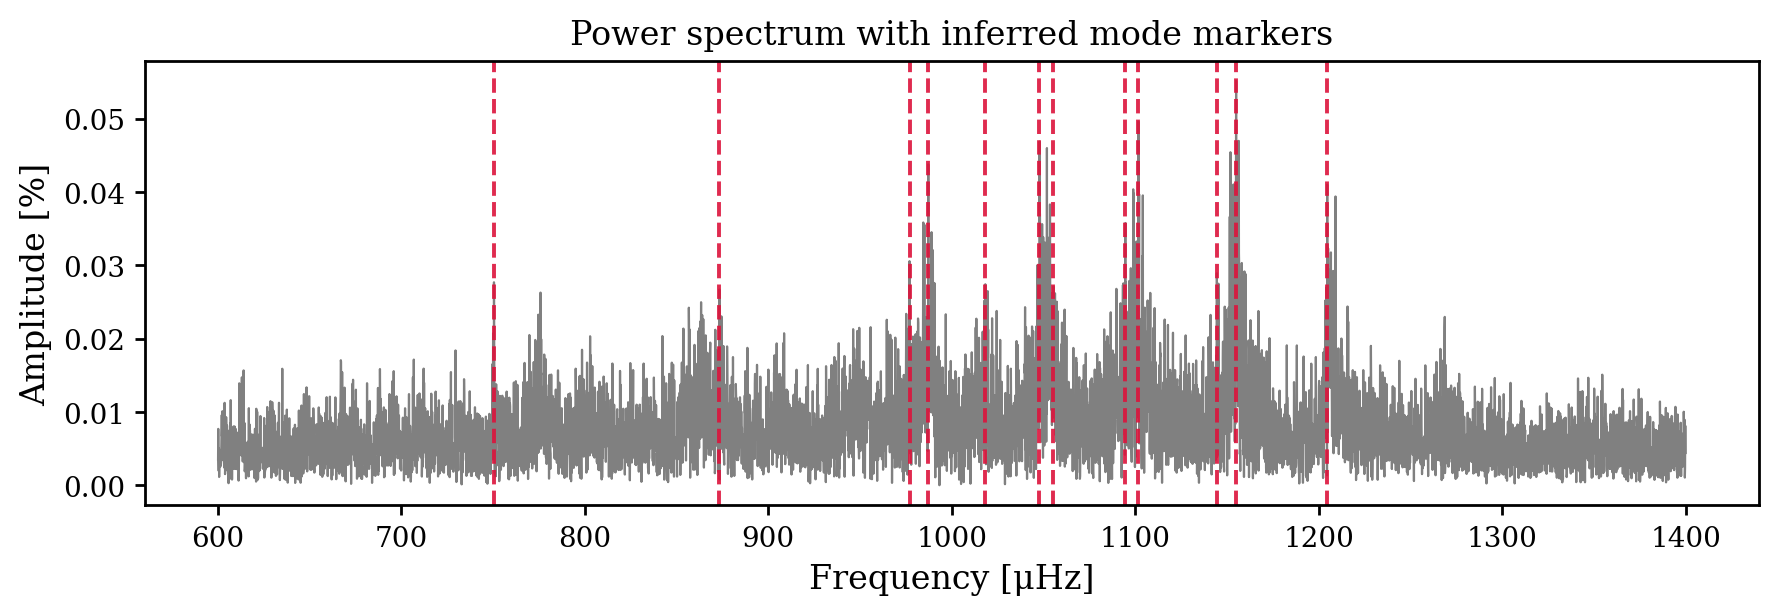

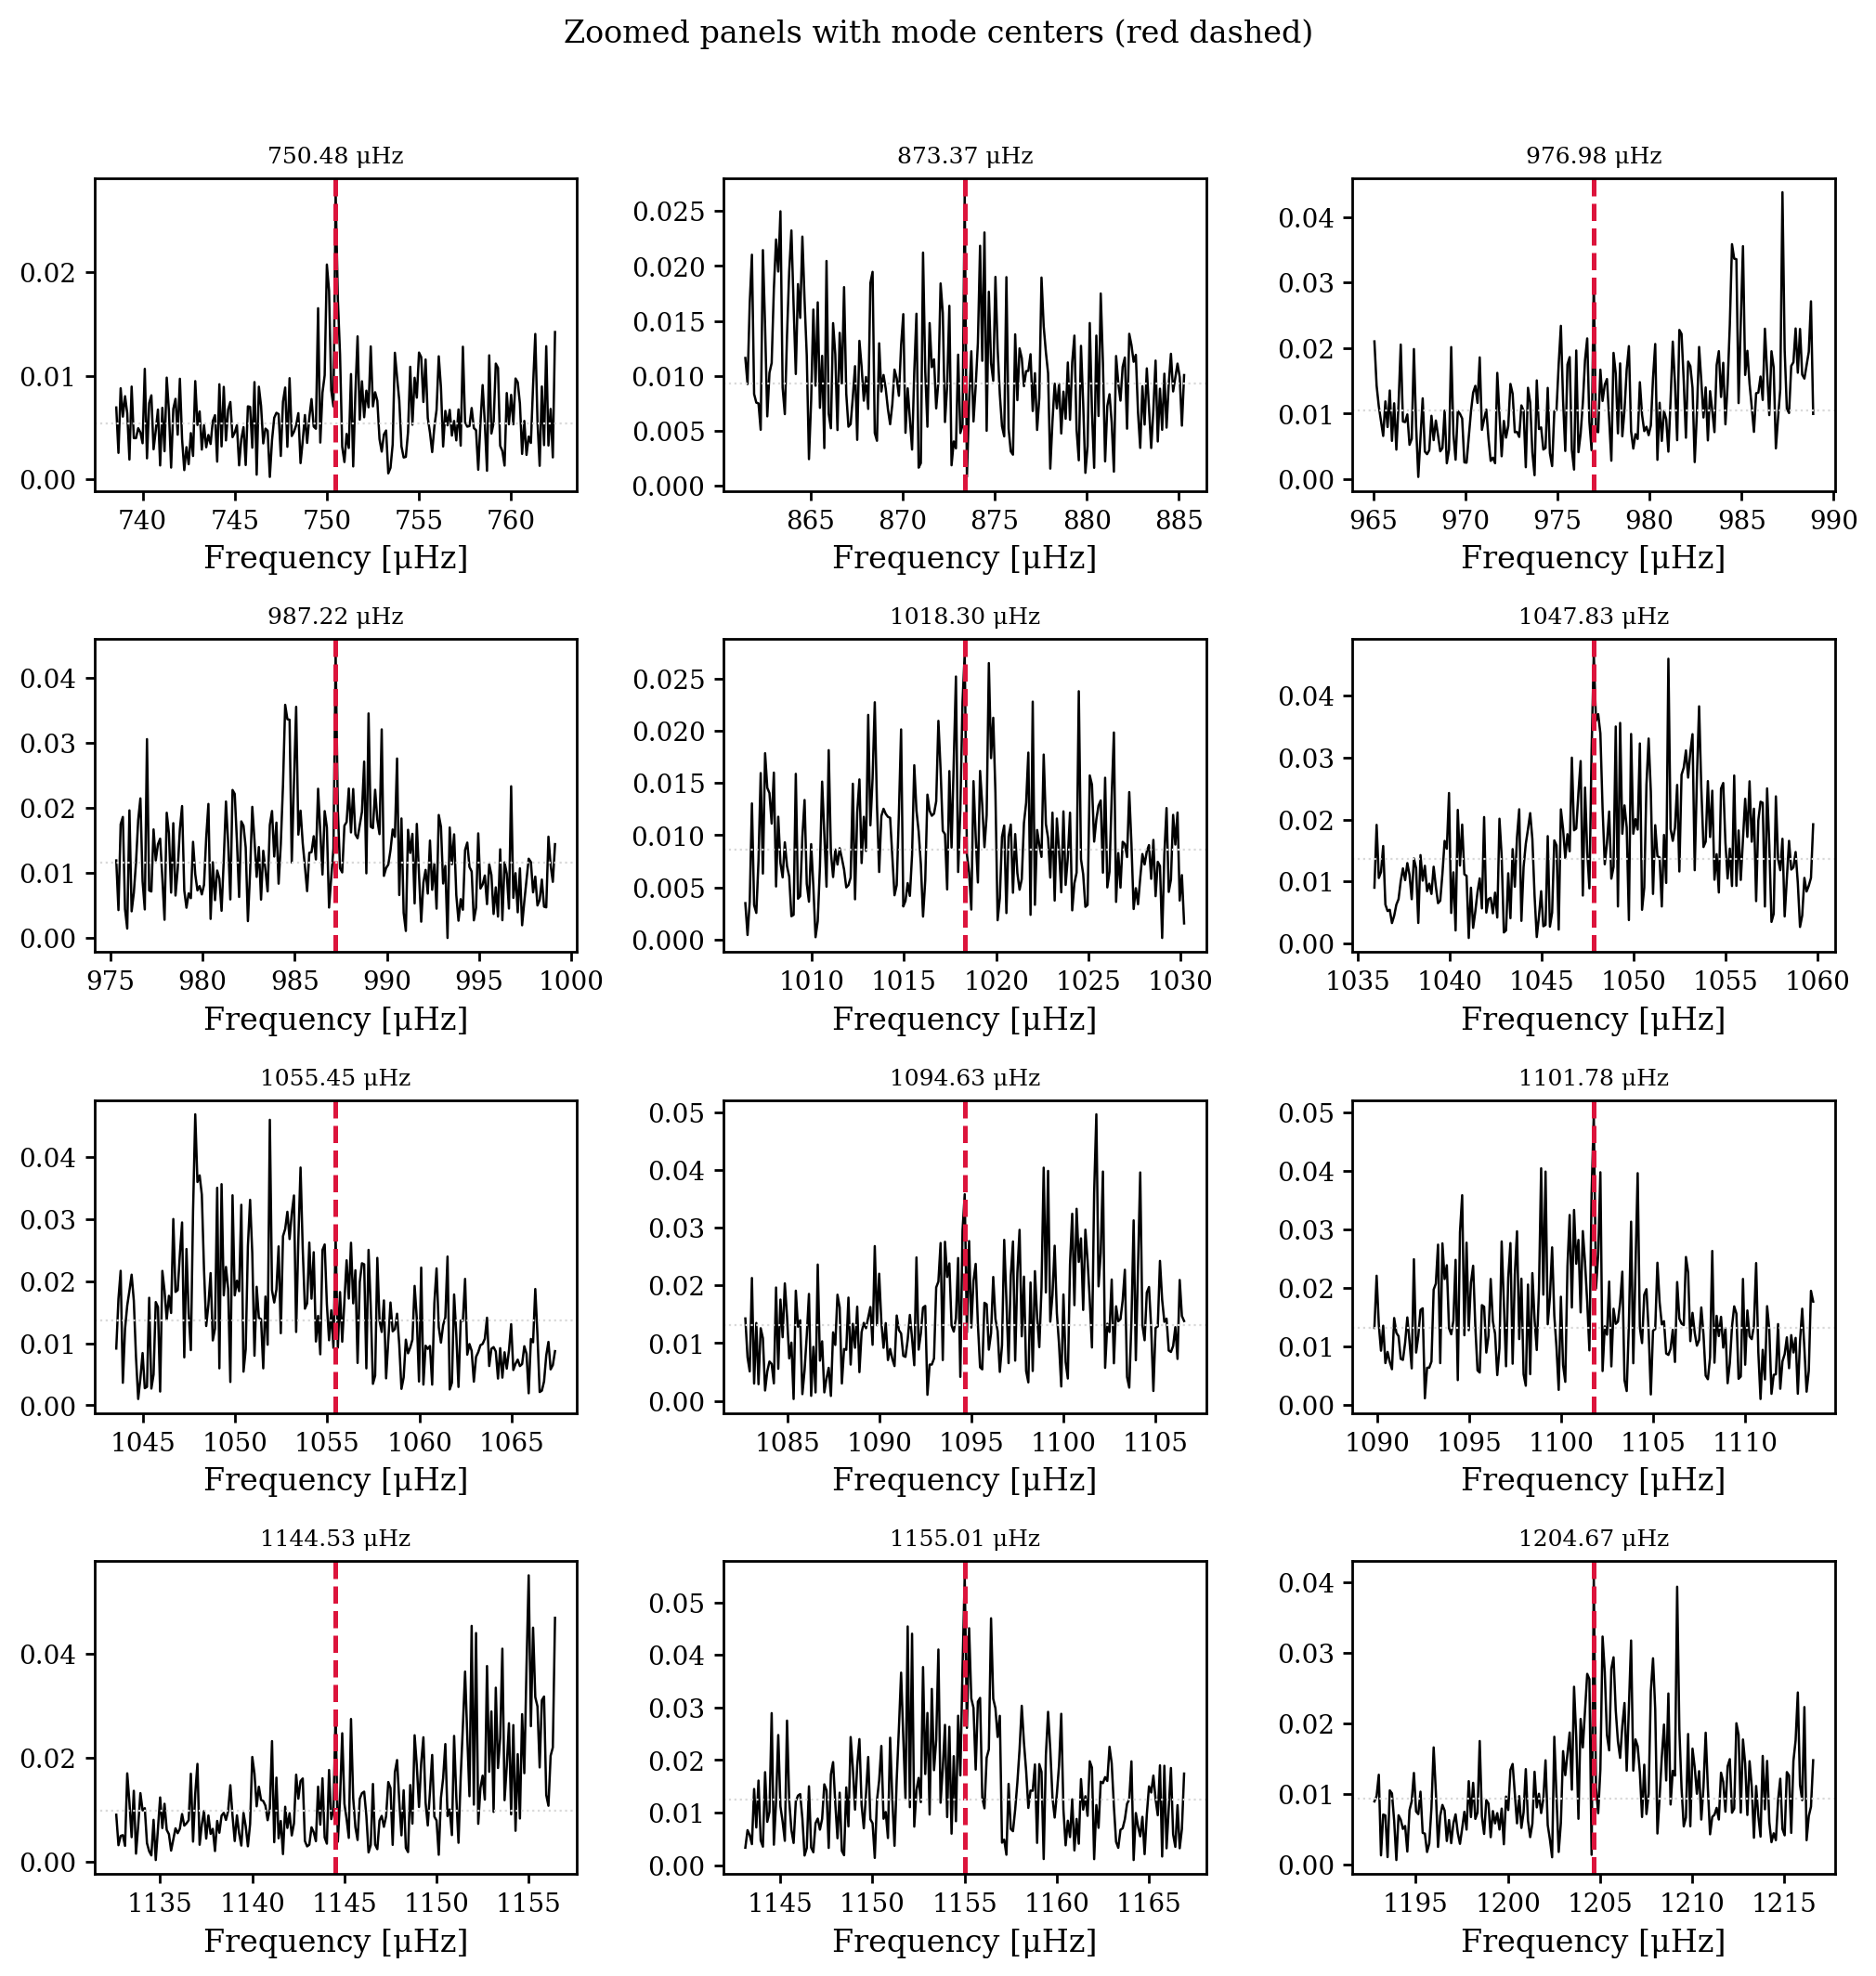

In [29]:
MED_WIDTH_uHz      = 300.0   # running
MIN_SNR            = 5.0     # keep peaks with S/N >= this on baseline-removed spectrum
PROM_FRAC          = 0.10    # prominence threshold = PROM_FRAC * 95th-percentile(residual)
MIN_SEP_uHz        = 7.0     # cluster distance to merge rotational multiplets
MAX_MODES          = 12      # keep strongest N mode clusters
REJECT_COMBOS      = True    # drop obvious linear-combination peaks
COMBO_TOL_uHz      = 1.0     # tolerance for combo checks
PANEL_HALFWIDTH_uHz= 12.0    # half-width of each zoom panel
NCOLS              = 3       # panels per row

PRIOR_FREQS_uHz    = []      


k_med = max(3, int(round(MED_WIDTH_uHz/df)) | 1)  
baseline = median_filter(P, size=k_med, mode="nearest")
R = np.clip(P - baseline, 0, None)              
mad = 1.4826 * np.median(np.abs(R - np.median(R)))
if not np.isfinite(mad) or mad <= 0:
    mad = np.std(R) if np.std(R) > 0 else 1e-12
snr = R / mad

# Peak seeding on residual
prom_thr = PROM_FRAC * np.percentile(R, 95.0)
pk, props = find_peaks(R,
                       distance=max(1, int(round(MIN_SEP_uHz/df))),
                       prominence=prom_thr)
if pk.size == 0:
    raise RuntimeError("No peaks found — relax PROM_FRAC or MIN_SNR.")

keep = snr[pk] >= MIN_SNR   # keeping high-S/N peaks only
pk = pk[keep]
if pk.size == 0:
    raise RuntimeError("No peaks pass MIN_SNR — lower MIN_SNR or widen band.")

order = np.argsort(R[pk])[::-1]
pk = pk[order][:max(MAX_MODES, 1)]
f_pk = f[pk]  # seed frequencies

# drop obvious linear combinations 
if REJECT_COMBOS and f_pk.size >= 3:
    mask = np.ones_like(f_pk, dtype=bool)

    for i in range(f_pk.size):
        if not mask[i]:
            continue
        fi = f_pk[i]
        combos = []
        for j in range(i):
            for k in range(j):
                fj, fk = f_pk[j], f_pk[k]
                combos.extend([abs(fj+fk), abs(fj-fk)])
        if len(combos):
            combos = np.asarray(combos)
            if np.min(np.abs(combos - fi)) < COMBO_TOL_uHz:
                mask[i] = False
    f_pk = f_pk[mask]

    pk = np.array([np.argmin(np.abs(f - val)) for val in f_pk])


seeds = np.sort(pk)
clusters = []
if seeds.size:
    cur = [seeds[0]]
    for idx in seeds[1:]:
        if (f[idx] - f[cur[-1]]) <= MIN_SEP_uHz:
            cur.append(idx)
        else:
            clusters.append(cur); cur = [idx]
    clusters.append(cur)

mode_freqs = []
for cl in clusters:
    w = np.maximum(R[cl], 1e-12)
    mode_freqs.append(np.sum(f[cl]*w)/np.sum(w))
mode_freqs = np.sort(np.array(mode_freqs))


mrows = []
for i, cl in enumerate(clusters, 1):
    mrows.append({
        "mode": i,
        "f_mode_uHz": mode_freqs[i-1],
        "members": len(cl),
        "f_members_uHz": ", ".join([f"{f[j]:.2f}" for j in cl])
    })
modes_df = pd.DataFrame(mrows)
display(modes_df)


fig, ax = plt.subplots(1, 1, figsize=(9, 3.2))
ax.plot(f, P_amp, color="0.5", lw=0.8)
for fm in mode_freqs:
    ax.axvline(fm, color="crimson", ls="--", lw=1.4, alpha=0.9)
for fp in PRIOR_FREQS_uHz:
    ax.axvline(fp, color="royalblue", ls="-.", lw=1.2, alpha=0.8)
ax.set_xlabel("Frequency [μHz]"); 
# ax.set_ylabel("Power [ppt$^2$/μHz]")
ax.set_ylabel("Amplitude [%]")
ax.set_title("Power spectrum with inferred mode markers")
plt.tight_layout()
plt.show()

n = len(mode_freqs)
if n == 0:
    print("No modes to plot.")
else:
    ncols = NCOLS
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.4*ncols, 2.6*nrows), squeeze=False)
    axes = axes.ravel()

    for i, fm in enumerate(mode_freqs):
        axp = axes[i]
        m = (f >= fm - PANEL_HALFWIDTH_uHz) & (f <= fm + PANEL_HALFWIDTH_uHz)
        axp.plot(f[m], P_amp[m], color="k", lw=0.9)
        axp.axvline(fm, color="crimson", ls="--", lw=1.8)  # observed mode (red)
        for fp in PRIOR_FREQS_uHz:
            if (fm - PANEL_HALFWIDTH_uHz) <= fp <= (fm + PANEL_HALFWIDTH_uHz):
                axp.axvline(fp, color="royalblue", ls="-.", lw=1.5, alpha=0.9)  # optional theory (blue)
        axp.set_title(f"{fm:.2f} μHz", fontsize=9)
        axp.set_xlabel("Frequency [μHz]"); 
        # axp.set_ylabel("Power")
        ax.set_ylabel("Amplitude [%]")
        axp.axhline(np.median(P_amp[m]), color="0.85", lw=0.8, ls=":")

    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    fig.suptitle("Zoomed panels with mode centers (red dashed)", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

Found 29 combinations at tol=0.50 µHz (Rayleigh=0.12 µHz). Parents used: 50, wide-band peaks: 50.


kind   i   j   k           fi           fj           fk        Ai  \
0   diff   1  41  26   153.143808  1206.573146  1053.310252  0.094222   
1    sum   1  26  41   153.143808  1053.310252  1206.573146  0.094222   
2    sum   0  13  17   102.770689   874.801256   977.452860  0.113528   
3   diff   0  17  13   102.770689   977.452860   874.801256  0.113528   
4   diff  26  41   1  1053.310252  1206.573146   153.143808  0.268467   
5   diff   0  16  12   102.770689   965.901578   863.249974  0.113528   
6    sum   0  12  16   102.770689   863.249974   965.901578  0.113528   
7   diff   1  40  25   153.143808  1205.382292  1052.119398  0.094222   
8    sum   1  25  40   153.143808  1052.119398  1205.382292  0.094222   
9   diff  25  40   1  1052.119398  1205.382292   153.143808  0.267287   
10   sum   1   9  18   153.143808   832.883200   985.788837  0.094222   
11  diff   1  18   9   153.143808   985.788837   832.883200  0.094222   
12  diff   9  18   1   832.883200   985.788837   153.143808  0.106401   
13   sum   0  24  36   102.770689  1050.452203  1153.580148  0.113528   
14  diff   0  36  24   102.770689  1153.580148  1050.452203  0.113528   
15   sum   0  18  28   102.770689   985.788837  1088.916783  0.113528   
16  diff  24  36   0  1050.452203  1153.580148   102.770689  0.245667   
17  diff  18  28   0   985.788837  1088.916783   102.770689  0.233909   
18  diff   0  28  18   102.770689  1088.916783   985.788837  0.113528   
19   sum   0  15  25   102.770689   949.705965  1052.119398  0.113528   
20  diff   1  33  19   153.143808  1141.314353   988.527801  0.094222   
21   sum   1  19  33   153.143808   988.527801  1141.314353  0.094222   
22  diff   0  25  15   102.770689  1052.119398   949.705965  0.113528   
23  diff  19  33   1   988.527801  1141.314353   153.143808  0.225284   
24   sum   0  25  37   102.770689  1052.119398  1154.413746  0.113528   

          Aj        Ak        df         Rc  |df|_uHz  
0   0.226855  0.268467 -0.119085   6.280000  0.119085  
1   0.268467  0.226855  0.119085   4.484121  0.119085  
2   0.140593  0.158185 -0.119085   4.955312  0.119085  
3   0.158185  0.140593  0.119085   3.914409  0.119085  
4   0.226855  0.094222 -0.119085   0.773539  0.119085  
5   0.132787  0.173624  0.119085   5.758702  0.119085  
6   0.173624  0.132787 -0.119085   3.368314  0.119085  
7   0.242276  0.267287 -0.119085   5.854467  0.119085  
8   0.267287  0.242276  0.119085   4.810050  0.119085  
9   0.242276  0.094222 -0.119085   0.727500  0.119085  
10  0.106401  0.233909 -0.238171  11.665980  0.238171  
11  0.233909  0.106401  0.238171   2.413880  0.238171  
12  0.233909  0.094222  0.238171   1.892916  0.238171  
13  0.245667  0.283376  0.357256   5.080242  0.357256  
14  0.283376  0.245667 -0.357256   3.818148  0.357256  
15  0.233909  0.150384  0.357256   2.831555  0.357256  
16  0.283376  0.113528 -0.357256   0.815381  0.357256  
17  0.150384  0.113528 -0.357256   1.613698  0.357256  
18  0.150384  0.233909 -0.357256   6.850342  0.357256  
19  0.126169  0.267287 -0.357256   9.330307  0.357256  
20  0.133785  0.225284  0.357256   8.935911  0.357256  
21  0.225284  0.133785 -0.357256   3.151361  0.357256  
22  0.267287  0.126169  0.357256   2.078937  0.357256  
23  0.133785  0.094222  0.357256   1.563087  0.357256  
24  0.267287  0.304172 -0.476342   5.011979  0.476342

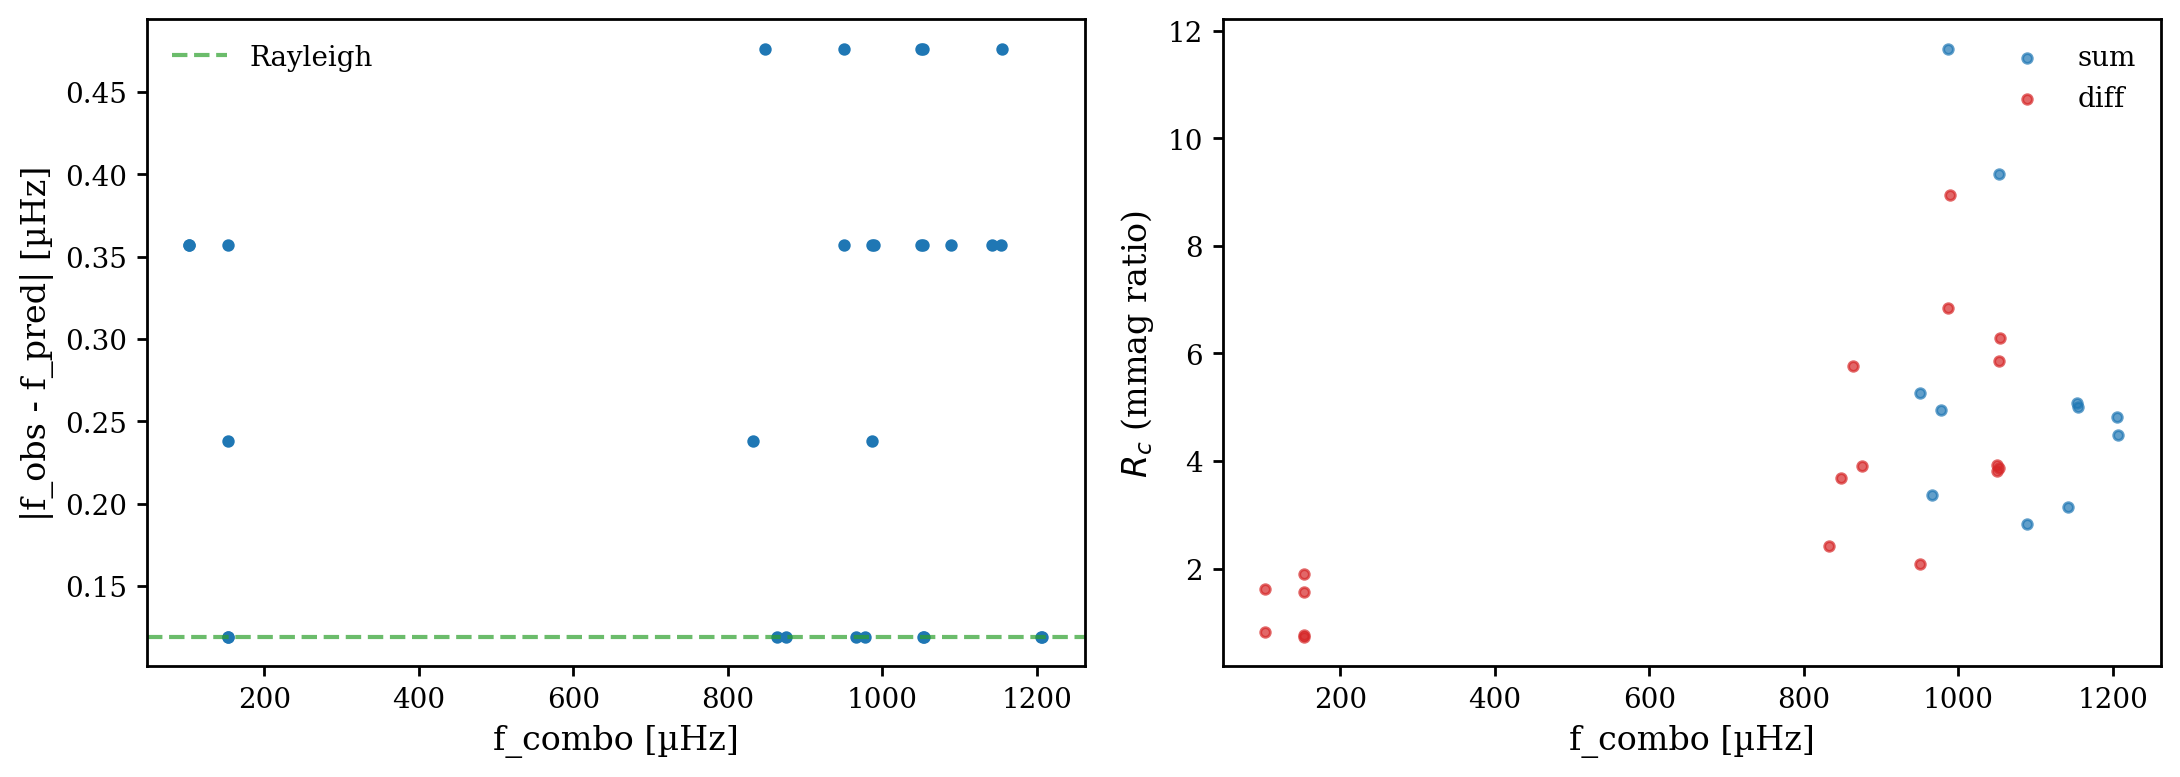

In [30]:
# 0) Pull a wide band from your periodogram (tweak limits if needed)
f_full = pg.frequency.to(u.uHz).value.astype(float)
P_full = pg.power.value.astype(float)
wide = (f_full >= 100.0) & (f_full <= 6000.0)   # wider than your parent band
f_w   = f_full[wide]
P_w   = P_full[wide]
df    = np.median(np.diff(f_w))

# 1) Smooth a little + detect MANY peaks across wide band
def smooth_boxcar(y, width_uHz):
    w = max(3, int(round(width_uHz/df)))
    return np.convolve(y, np.ones(w)/w, mode="same")

P_ws  = smooth_boxcar(P_w, 3.0)                              # ~3 μHz boxcar
prom0 = 0.20*np.percentile(P_ws, 99.0)                       # be inclusive
pk_all, props = find_peaks(P_ws, prominence=prom0, distance=max(1,int(round(0.6/df))))
f_all = f_w[pk_all]
P_all = P_ws[pk_all]

# 2) Amplitude proxy for ranking (relative is fine for Rc)
A_rel = np.sqrt(np.maximum(P_all, 0.0) * df)                 # ~ppt (rel.)
A_mmag = 1.086*A_rel                                         # mmag approx.

# 3) Choose parents from the stronger wide-band peaks
Nparents = min(80, len(f_all))
parents_ix = np.argsort(A_mmag)[-Nparents:]
parents_ix.sort()
f_par   = f_all[parents_ix]
A_par   = A_mmag[parents_ix]

# 4) Adaptive tolerance & band edges for reporting
T_days = lc.time.jd.max() - lc.time.jd.min()
rayleigh = 1e6/(T_days*86400.0)
fmin, fmax = f_all.min(), f_all.max()

def find_combos_match_to_all(f_par, A_par, f_all, tol):
    rows, missed = [], []
    # map: for quick nearest-peak search
    for i in range(len(f_par)):
        # harmonic 2*fi
        f_pred = 2.0*f_par[i]
        if (f_pred < fmin) or (f_pred > fmax):
            missed.append(("harm", i, i, f_pred))
        else:
            j = np.argmin(np.abs(f_all - f_pred))
            if abs(f_all[j]-f_pred) <= tol:
                rows.append(dict(kind="harm", i=i, j=i, k=j,
                                 fi=f_par[i], fj=f_par[i], fk=f_all[j],
                                 Ai=A_par[i], Aj=A_par[i],
                                 Ak=A_mmag[np.where(f_all==f_all[j])[0][0]],
                                 df=f_all[j]-f_pred))
    # sums/diffs
    for i, j in combinations(range(len(f_par)), 2):
        # sum
        f_pred = f_par[i] + f_par[j]
        if (f_pred < fmin) or (f_pred > fmax):
            missed.append(("sum", i, j, f_pred))
        else:
            k = np.argmin(np.abs(f_all - f_pred))
            if abs(f_all[k]-f_pred) <= tol:
                rows.append(dict(kind="sum", i=i, j=j, k=k,
                                 fi=f_par[i], fj=f_par[j], fk=f_all[k],
                                 Ai=A_par[i], Aj=A_par[j],
                                 Ak=A_mmag[np.where(f_all==f_all[k])[0][0]],
                                 df=f_all[k]-f_pred))
        # diff (positive)
        f_pred = abs(f_par[i] - f_par[j])
        if (f_pred < fmin) or (f_pred > fmax):
            missed.append(("diff", i, j, f_pred))
        else:
            k = np.argmin(np.abs(f_all - f_pred))
            if abs(f_all[k]-f_pred) <= tol:
                rows.append(dict(kind="diff", i=i, j=j, k=k,
                                 fi=f_par[i], fj=f_par[j], fk=f_all[k],
                                 Ai=A_par[i], Aj=A_par[j],
                                 Ak=A_mmag[np.where(f_all==f_all[k])[0][0]],
                                 df=f_all[k]-f_pred))
    return pd.DataFrame(rows), pd.DataFrame(missed, columns=["kind","i","j","f_pred_uHz"])

# 5) Sweep tolerances until we get hits
tol_grid = [max(0.5, 0.6*rayleigh), 0.8, 1.0, 1.5, 2.0]
found, tol_used, missed_all = None, None, None
for tol in tol_grid:
    comb, missed = find_combos_match_to_all(f_par, A_par, f_all, tol)
    if not comb.empty:
        found, tol_used, missed_all = comb.sort_values("kind"), tol, missed
        break
if found is None:
    _, missed_all = find_combos_match_to_all(f_par, A_par, f_all, tol_grid[-1])
    print(f"No combinations found up to tol={tol_grid[-1]:.2f} µHz.\n"
          f"Wide-band peaks detected: {len(f_all)} (band [{fmin:.1f},{fmax:.1f}] µHz).\n"
          "Try lowering the prominence or widening the band further.")
else:
    # Yeates Rc
    nij = np.where(found["kind"].eq("harm"), 1.0, 2.0)
    found["Rc"] = found["Ak"] / (nij * found["Ai"] * found["Aj"] + 1e-12)
    found["|df|_uHz"] = np.abs(found["df"])
    found = found.sort_values(["|df|_uHz","Ak"], ascending=[True, False]).reset_index(drop=True)
    print(f"Found {len(found)} combinations at tol={tol_used:.2f} µHz "
          f"(Rayleigh={rayleigh:.2f} µHz). Parents used: {len(f_par)}, wide-band peaks: {len(f_all)}.")
    display(found.head(25))

    # quick plots
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1,2, figsize=(11,4))
    ax[0].scatter(found["fk"], found["|df|_uHz"], s=12)
    ax[0].axhline(rayleigh, ls="--", color="tab:green", alpha=0.7, label="Rayleigh")
    ax[0].set_xlabel("f_combo [µHz]"); ax[0].set_ylabel("|f_obs - f_pred| [µHz]"); ax[0].legend(frameon=False)
    for kind, col in [("harm","tab:orange"),("sum","tab:blue"),("diff","tab:red")]:
        m = found["kind"].eq(kind)
        if m.any():
            ax[1].scatter(found.loc[m,"fk"], found.loc[m,"Rc"], s=12, label=kind, alpha=0.7, color=col)
    ax[1].set_xlabel("f_combo [µHz]"); ax[1].set_ylabel(r"$R_c$ (mmag ratio)"); ax[1].legend(frameon=False)
    plt.tight_layout(); plt.show()

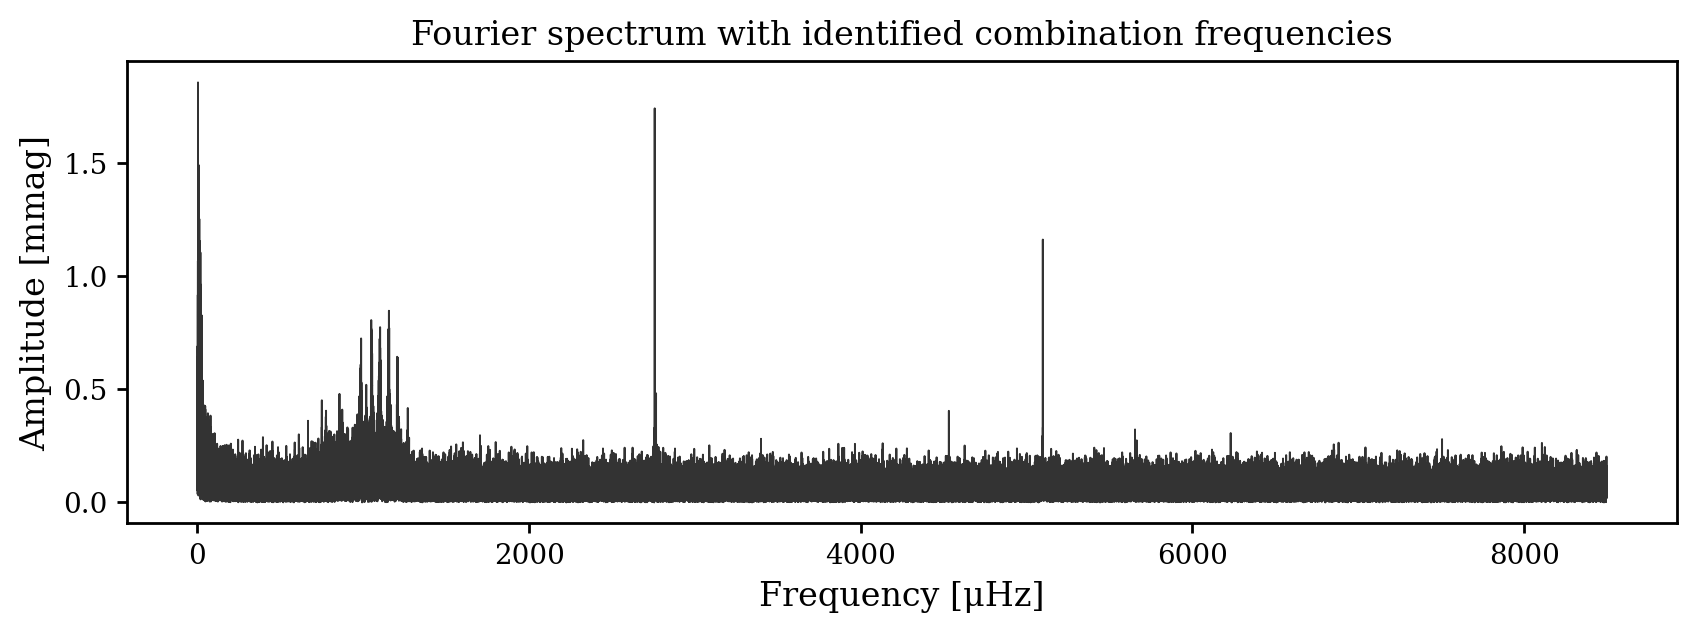

In [31]:
pgA = lc.normalize(unit='ppm').to_periodogram(normalization='amplitude')
# amplitudes are in ppm; convert to mmag:
# small-signal: Δm [mag] ≈ -1.0857 * ΔF/F, so 1 ppm = 1e-6 in flux ≈ 1.0857e-6 mag = 0.0010857 mmag
amp_mmag = pgA.power.value * 0.0010857   # ppm → mmag
f_uHz     = pgA.frequency.to(u.uHz).value

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(f_uHz, amp_mmag, color='0.2', lw=0.7)
ax.set(xlabel='Frequency [μHz]', ylabel='Amplitude [mmag]',
       title='Fourier spectrum with identified combination frequencies')

####################################
def normalize_combos(combos):
    # 1) Already a DataFrame
    if isinstance(combos, pd.DataFrame):
        df = combos.copy()
    # 2) Dict of arrays
    elif isinstance(combos, dict):
        df = pd.DataFrame(combos)
    # 3) List of dicts
    elif isinstance(combos, (list, tuple)) and len(combos) and isinstance(combos[0], dict):
        df = pd.DataFrame(combos)
    else:
        arr = np.asarray(combos, dtype=object)
        # 4) Structured/rec array
        if getattr(arr, "dtype", None) is not None and arr.dtype.names:
            df = pd.DataFrame({k: arr[k] for k in arr.dtype.names})
        else:
            # 5) Plain list/array of tuples
            arr = np.atleast_2d(arr)
            if arr.shape[1] >= 5:
                df = pd.DataFrame(arr[:, :5],
                                  columns=["f_obs_uHz","f_pred_uHz","delta_f_uHz","A_combo_mmag","kind"])
            elif arr.shape[1] == 4:
                f_obs, f_pred, delta_f, kind = arr.T
                df = pd.DataFrame(dict(f_obs_uHz=f_obs, f_pred_uHz=f_pred,
                                       delta_f_uHz=delta_f, A_combo_mmag=np.nan, kind=kind))
            elif arr.shape[1] == 3:
                f_obs, f_pred, kind = arr.T
                f_obs = np.asarray(f_obs, float); f_pred = np.asarray(f_pred, float)
                df = pd.DataFrame(dict(f_obs_uHz=f_obs, f_pred_uHz=f_pred,
                                       delta_f_uHz=np.abs(f_obs - f_pred),
                                       A_combo_mmag=np.nan, kind=kind))
            else:
                raise TypeError("`combos` must be a DataFrame/dict, a structured array, "
                                "or an (N,3–5) array/list of tuples.")

    # Harmonize column names if different
    rename_map = {
        "f_obs": "f_obs_uHz", "f_pred": "f_pred_uHz", "delta_f": "delta_f_uHz",
        "A_combo": "A_combo_mmag", "amp_mmag": "A_combo_mmag", "amplitude_mmag": "A_combo_mmag",
        "type": "kind", "class": "kind"
    }
    for k, v in rename_map.items():
        if k in df.columns and v not in df.columns:
            df[v] = df[k]

    # Ensure required columns
    for col in ["f_obs_uHz","f_pred_uHz","delta_f_uHz","kind"]:
        if col not in df.columns:
            raise TypeError(f"Missing required column '{col}' after normalization.")

    if "A_combo_mmag" not in df.columns:
        df["A_combo_mmag"] = np.nan

    # Cast to numeric where appropriate
    for c in ["f_obs_uHz","f_pred_uHz","delta_f_uHz","A_combo_mmag"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["kind"] = df["kind"].astype(str)
    return df


combos_df = normalize_combos(combos).reset_index(drop=True)
# keep matches within Rayleigh resolution
combos_df = combos_df[combos_df["delta_f_uHz"] <= rayleigh_uHz]
####################################

   #  
for row in combos_df.itertuples():
    if row.delta_f_uHz <= rayleigh_uHz:     # good matches only
        # arrow/marker
        ax.vlines(row.f_obs_uHz, 0, row.A_combo_mmag, color=('C0' if row.kind=='sum' else 'C3'),
                  lw=1.2, alpha=0.9)
        # text label like "F1+F3" or "2F2"
        ax.text(row.f_obs_uHz, row.A_combo_mmag*1.05, row.label,
                color=('C0' if row.kind=='sum' else 'C3'),
                fontsize=8, rotation=90, ha='center', va='bottom')


Baseline T ≈ 97.20 d  |  Rayleigh ≈ 0.119 μHz  |  tol = 1.00 μHz
Parents used: 50  |  All peaks available: 6187  |  Combos kept: 2539


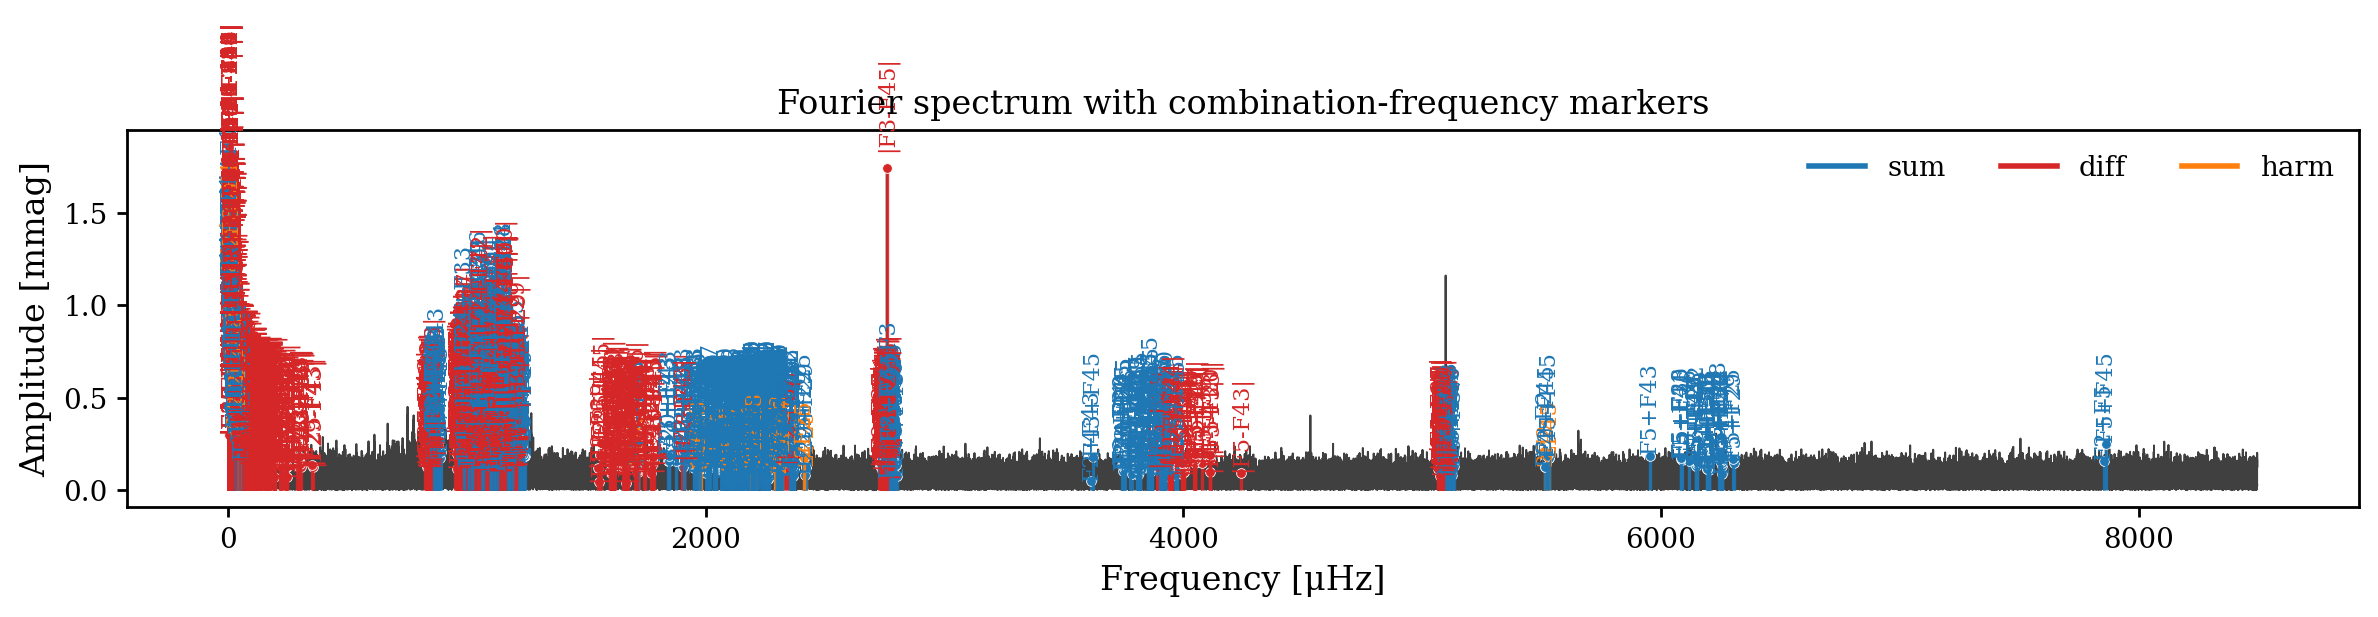

In [32]:


# ----------------- 1) Rayleigh resolution -----------------
T_days = float(lc.time.jd.max() - lc.time.jd.min())
rayleigh_uHz = 1e6 / (T_days * 86400.0)

# ----------------- 2) Observed peaks (parents + all peaks) -----------------
# Find peaks on amplitude spectrum; use prominence to avoid noise
df = np.median(np.diff(f_uHz))
min_dist_bins = max(1, int(round(1.0/df)))   # ~1 μHz separation
pk, _ = find_peaks(amp_mmag, distance=min_dist_bins)
if pk.size == 0:
    raise RuntimeError("No peaks found; relax 'distance' or check amp_mmag.")

prom = peak_prominences(amp_mmag, pk)[0]
order = np.argsort(prom)[::-1]

# Parents: top N by prominence
Nparents = min(50, pk.size)
parents_idx = pk[order[:Nparents]]
f_par  = f_uHz[parents_idx]
A_par  = amp_mmag[parents_idx]

# All peaks for matching (denser list helps matching combos)
all_idx  = pk
f_all    = f_uHz[all_idx]
A_all    = amp_mmag[all_idx]

# ----------------- 3) Build predicted combinations -----------------
rows = []
fmin, fmax = f_uHz.min(), f_uHz.max()
tol_uHz = max(1.5*rayleigh_uHz, 1.0)   # try ≤1.5×Rayleigh, but at least 1 μHz

# sums & diffs
for i in range(len(f_par)):
    for j in range(i, len(f_par)):
        fi, fj = f_par[i], f_par[j]
        Ai, Aj = A_par[i], A_par[j]

        # sum
        f_pred = fi + fj
        if fmin <= f_pred <= fmax:
            k = int(np.argmin(np.abs(f_all - f_pred)))
            f_obs = float(f_all[k]); d = abs(f_obs - f_pred)
            if d <= tol_uHz:
                rows.append(dict(kind="sum", i=i, j=j, f_pred_uHz=f_pred,
                                 f_obs_uHz=f_obs, delta_f_uHz=d,
                                 A_combo_mmag=float(A_all[k]), Ai_mmag=Ai, Aj_mmag=Aj,
                                 label=f"F{i+1}+F{j+1}"))

        # diff
        f_pred = abs(fi - fj)
        if fmin <= f_pred <= fmax:
            k = int(np.argmin(np.abs(f_all - f_pred)))
            f_obs = float(f_all[k]); d = abs(f_obs - f_pred)
            if d <= tol_uHz:
                rows.append(dict(kind="diff", i=i, j=j, f_pred_uHz=f_pred,
                                 f_obs_uHz=f_obs, delta_f_uHz=d,
                                 A_combo_mmag=float(A_all[k]), Ai_mmag=Ai, Aj_mmag=Aj,
                                 label=f"|F{i+1}-F{j+1}|"))

# simple harmonics (2f)
for i in range(len(f_par)):
    fi, Ai = f_par[i], A_par[i]
    f_pred = 2.0*fi
    if fmin <= f_pred <= fmax:
        k = int(np.argmin(np.abs(f_all - f_pred)))
        f_obs = float(f_all[k]); d = abs(f_obs - f_pred)
        if d <= tol_uHz:
            rows.append(dict(kind="harm", i=i, j=i, f_pred_uHz=f_pred,
                             f_obs_uHz=f_obs, delta_f_uHz=d,
                             A_combo_mmag=float(A_all[k]), Ai_mmag=Ai, Aj_mmag=Ai,
                             label=f"2F{i+1}"))

combos_df = pd.DataFrame(rows)
print(f"Baseline T ≈ {T_days:.2f} d  |  Rayleigh ≈ {rayleigh_uHz:.3f} μHz  |  tol = {tol_uHz:.2f} μHz")
print(f"Parents used: {len(f_par)}  |  All peaks available: {len(f_all)}  |  Combos kept: {len(combos_df)}")

if combos_df.empty:
    print("No combination frequencies to plot. Consider increasing Nparents or tol_uHz.")
else:
    # optional strength metric like Yeates
    combos_df["Rc"] = combos_df["A_combo_mmag"] / (combos_df["Ai_mmag"] * combos_df["Aj_mmag"]).replace(0, np.nan)

    # ----------------- 4) Overlay on spectrum -----------------
    import matplotlib.pyplot as plt
    kind_color = {'sum':'C0', 'diff':'C3', 'harm':'C1'}

    # evaluate y at each f_obs (use amplitude array directly)
    def y_at(freq_uHz):
        k = int(np.argmin(np.abs(f_uHz - freq_uHz)))
        return amp_mmag[k], f_uHz[k]

    vals_bins = [y_at(fr) for fr in combos_df["f_obs_uHz"].values]
    combos_df["y_here"] = [vb[0] for vb in vals_bins]
    combos_df["f_bin"]  = [vb[1] for vb in vals_bins]
    combos_df["A_plot"] = combos_df["A_combo_mmag"].fillna(combos_df["y_here"])
    combos_df = combos_df.sort_values("A_plot")  # draw weakest first

    fig, ax = plt.subplots(figsize=(12, 3.2))
    ax.plot(f_uHz, amp_mmag, color='0.25', lw=0.7, label='Amplitude FT')

    for _, r in combos_df.iterrows():
        c = kind_color.get(r["kind"], 'k')
        ax.vlines(r["f_bin"], 0, r["A_plot"], color=c, lw=1.2, alpha=0.9)
        ax.plot([r["f_bin"]], [r["A_plot"]], 'o', ms=3.5, color=c, mec='white', mew=0.3)
        # tiny label just above the marker
        ax.text(r["f_bin"], r["A_plot"]*1.05, r["label"], color=c, fontsize=8,
                rotation=90, ha='center', va='bottom')

    from matplotlib.lines import Line2D
    kinds_present = combos_df["kind"].unique()
    handles = [Line2D([0],[0], color=kind_color[k], lw=2, label=k) for k in ['sum','diff','harm'] if k in kinds_present]
    if handles: ax.legend(handles=handles, frameon=False, ncol=len(handles))

    ax.set(xlabel='Frequency [μHz]', ylabel='Amplitude [mmag]',
           title='Fourier spectrum with combination-frequency markers')
    plt.tight_layout(); plt.show()


In [ ]:


# ---- CONFIG ----
# Option A: fixed windows you choose
windows = [(800, 1200), (800, 1600), (1600, 2600), (2600, 3600), (3600, 5200), (5200, 7000), (7000, 9000)]

# Option B: auto-split full range into K equal-width chunks
K = 6
fmin, fmax = float(f_uHz.min()), float(f_uHz.max())
edges = np.linspace(fmin, fmax, K+1)
# windows = [(edges[i], edges[i+1]) for i in range(K)]

# Optional: light de-clutter (only annotate combos above this local SNR)
def local_snr(f0, width=150.0):  # μHz half-width window
    m = (f_uHz >= f0-width) & (f_uHz <= f0+width)
    if not np.any(m): 
        return np.nan
    med = np.median(amp_mmag[m])
    mad = 1.4826*np.median(np.abs(amp_mmag[m] - med))
    return (amp_mmag[np.argmin(np.abs(f_uHz - f0))] - med) / (mad + 1e-12)

SNR_MIN = 3.0   # increase to be stricter

# Build colors once
kind_color = {'sum':'C0', 'diff':'C3', 'harm':'C1'}

# ===== keep only prominent combinations =====
def order_from_label(s: str) -> int:
    # counts how many parents, e.g. "F12+F7" -> 2, "F3+F4+F21" -> 3
    return 0 if not isinstance(s, str) else s.count("F")

def local_snr(f0, width=150.0):
    m = (f_uHz >= f0-width) & (f_uHz <= f0+width)
    if not np.any(m): 
        return np.nan
    med = np.median(amp_mmag[m])
    mad = 1.4826*np.median(np.abs(amp_mmag[m] - med))
    y   = amp_mmag[np.argmin(np.abs(f_uHz - f0))]
    return (y - med) / (mad + 1e-12)

# evaluate spectrum height, bin, snr
def y_at(freq_uHz):
    k = int(np.argmin(np.abs(f_uHz - freq_uHz)))
    return amp_mmag[k], float(f_uHz[k]), k

vals = [y_at(fr) for fr in combos_df['f_obs_uHz'].to_numpy()]
combos_df = combos_df.copy()
combos_df['y_here']  = [v[0] for v in vals]
combos_df['f_bin']   = [v[1] for v in vals]
combos_df['idx_bin'] = [v[2] for v in vals]
combos_df['snr']     = combos_df['f_bin'].apply(local_snr)
combos_df['order']   = combos_df['label'].apply(order_from_label)

# --- hard filters: good frequency match + decent SNR + simple (2-parent) combos only
SNR_MIN        = 4.0                  # tighten to show only strong lines
MATCH_TOL_UHZ  = 0.6 * rayleigh_uHz   # stricter than Rayleigh
MAX_ORDER      = 2                    # keep sums/diffs (2 parents) only
ALLOWED_KINDS  = {'sum','diff','harm'}

show = combos_df.query(
    'delta_f_uHz <= @MATCH_TOL_UHZ and snr >= @SNR_MIN and order <= @MAX_ORDER'
).copy()
show = show[show['kind'].isin(ALLOWED_KINDS)]

# --- de-duplicate near-identical markers (keep strongest within 2 µHz)
show = show.sort_values('y_here', ascending=False)
picked = []
for _, r in show.iterrows():
    if all(abs(r['f_bin'] - p['f_bin']) >= 2.0 for p in picked):
        picked.append(r)
show = pd.DataFrame(picked)

# --- optionally limit count per frequency window (top N by height)
TOP_PER_WINDOW = 8
def topN_in_window(df, lo, hi, n=TOP_PER_WINDOW):
    m = (df['f_bin'] >= lo) & (df['f_bin'] <= hi)
    return df.loc[m].nlargest(n, 'y_here')

# rebuild the 'show' table from your windows list
kept_chunks = []
for lo, hi in windows:
    kept_chunks.append(topN_in_window(show, lo, hi))
show = pd.concat(kept_chunks, ignore_index=True)



# Skip if nothing to show
if 'combos_df' not in globals() or combos_df.empty:
    print("No combination frequencies to plot.")
else:
    # Compute plotted bin/height and SNR for each combo once
    def y_at(freq_uHz):
        k = int(np.argmin(np.abs(f_uHz - freq_uHz)))
        return amp_mmag[k], float(f_uHz[k]), k

    vals = [y_at(fr) for fr in combos_df['f_obs_uHz'].to_numpy()]
    combos_df = combos_df.copy()
    combos_df['y_here']  = [v[0] for v in vals]
    combos_df['f_bin']   = [v[1] for v in vals]
    combos_df['idx_bin'] = [v[2] for v in vals]
    combos_df['snr']     = combos_df['f_bin'].apply(local_snr)

    # Keep only decent matches & decent SNR
    show = combos_df.query('delta_f_uHz <= @rayleigh_uHz and snr >= @SNR_MIN').copy()
    # Draw weaker first
    show.sort_values('y_here', inplace=True)

    # ----- figure -----
    ncols = min(3, len(windows))
    nrows = int(np.ceil(len(windows)/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, 2.6*nrows), sharey=False)
    axes = np.atleast_1d(axes).ravel()

    for ax, (lo, hi) in zip(axes, windows):
        # base spectrum
        m = (f_uHz >= lo) & (f_uHz <= hi)
        if not np.any(m):
            ax.axis('off'); continue
        ax.plot(f_uHz[m], amp_mmag[m], color='0.3', lw=0.7)

        # combos in this window
        csel = (show['f_bin'] >= lo) & (show['f_bin'] <= hi)
        chunk = show.loc[csel]

        # optional: cap number of text labels per panel
        MAX_LABELS = 35
        to_label = chunk.tail(MAX_LABELS)  # strongest N

        # stems
        for _, r in chunk.iterrows():
            c = kind_color.get(r['kind'], 'k')
            ax.vlines(r['f_bin'], 0, r['y_here'], color=c, lw=1.1, alpha=0.9)
            ax.plot(r['f_bin'], r['y_here'], 'o', ms=3.2, color=c, mec='white', mew=0.3)

        # labels (only for strongest)
        for _, r in to_label.iterrows():
            c = kind_color.get(r['kind'], 'k')
            ax.text(r['f_bin'], r['y_here']*1.04, r['label'], color=c, rotation=90,
                    ha='center', va='bottom', fontsize=7)

        ax.set_xlim(lo, hi)
        ax.set_xlabel('Frequency [μHz]')
        ax.set_ylabel('Amplitude [mmag]')
        ax.set_title(f'{lo:,.0f}–{hi:,.0f} μHz')

    # hide unused axes
    for k in range(len(windows), len(axes)):
        axes[k].axis('off')

    # one legend
    handles = [Line2D([0],[0], color=v, lw=2, label=k) for k, v in kind_color.items()
               if k in show['kind'].unique()]
    if handles:
        fig.legend(handles=handles, loc='upper center', ncol=len(handles), frameon=False)

    fig.suptitle('Combination frequencies by frequency chunk', y=1.02, fontsize=14)
    fig.tight_layout()
    plt.show()


### Pin pointing only the prominent peaks from Lorentzian sum

[diag] parents=11  candidates=132  Rayleigh=0.119 μHz  TOL=1.500
[diag] within Rayleigh: 9  | SNR≥cut: 22


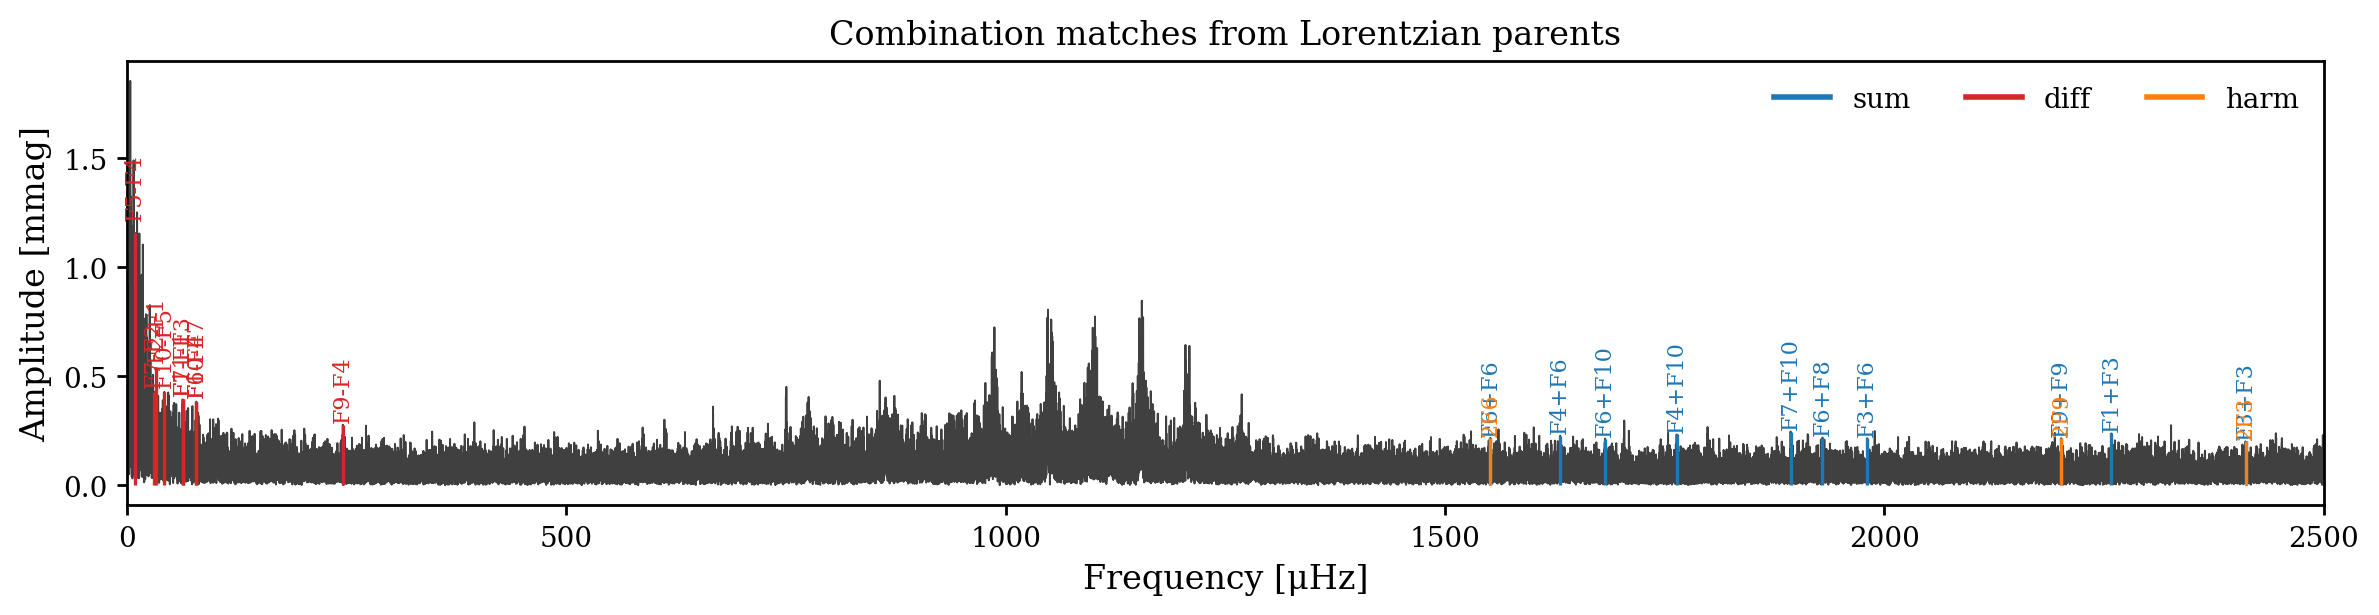

In [ ]:
# --- 1) parents from Lorentz fits (sort by local amplitude) ---
parents_freq = np.asarray(fit_tab["nu0_uHz"], float)          # fitted centers
# get amplitude at those centers
def amp_at(nu):
    i = int(np.argmin(np.abs(f_uHz - nu)))
    return float(amp_mmag[i]), float(f_uHz[i])
amps_bins = [amp_at(nu) for nu in parents_freq]
amps, bins = map(np.array, zip(*amps_bins))

parents = (pd.DataFrame(dict(nu_uHz=bins, A_mmag=amps))
             .sort_values("A_mmag", ascending=False)
             .reset_index(drop=True))

# ---------- PARAMETERS YOU CAN LOOSEN/TIGHTEN ----------
N_PARENTS   = 14      # how many strongest Lorentz parents
MIN_SEP_uHz = 4.0     # enforce parent deblending
TOL         = max(2*rayleigh_uHz, 1.5)   # match window (μHz)
SNR_MIN     = 3.5     # keep combos with SNR ≥ this
KEEP_PER_2u = 2       # max labels per ±2 μHz region
# ------------------------------------------------------

pfreq  = parents.nu_uHz.values
pamp   = parents.A_mmag.values

# (rebuild parents with these settings)
parents = (pd.DataFrame(dict(nu_uHz=pfreq, A_mmag=pamp))
           .sort_values("A_mmag", ascending=False)
           .reset_index(drop=True))
keep=[]
for _, r in parents.iterrows():
    if all(abs(r.nu_uHz-parents.loc[k,"nu_uHz"])>=MIN_SEP_uHz for k in keep):
        keep.append(r.name)
    if len(keep)>=N_PARENTS: break
parents = parents.loc[keep].reset_index(drop=True)
parents["label"]=[f"F{i+1}" for i in range(len(parents))]
plabel = parents.label.values


def nearest_peak(freq, tol):
    m = (f_uHz>=freq-tol) & (f_uHz<=freq+tol)
    if not np.any(m): return None
    k = np.argmax(amp_mmag[m])
    x = f_uHz[m][k]; y = amp_mmag[m][k]
    return dict(f_obs_uHz=float(x), A_combo_mmag=float(y))

rows=[]
M=len(parents)
for i in range(M):
    for j in range(i,M):
        fi,fj=pfreq[i],pfreq[j]
        # sum
        h=nearest_peak(fi+fj, TOL)
        if h: rows.append({"label":f"{plabel[i]}+{plabel[j]}","kind":"sum","f_pred_uHz":fi+fj,**h})
        # diff
        d=abs(fi-fj)
        if d>0:
            h=nearest_peak(d, TOL)
            if h: rows.append({"label":f"{plabel[max(i,j)]}-{plabel[min(i,j)]}","kind":"diff","f_pred_uHz":d,**h})
# harmonics
for i in range(M):
    h=nearest_peak(2*pfreq[i], TOL)
    if h: rows.append({"label":f"2{plabel[i]}","kind":"harm","f_pred_uHz":2*pfreq[i],**h})

combos_df=pd.DataFrame(rows)
print(f"[diag] parents={len(parents)}  candidates={len(combos_df)}  Rayleigh={rayleigh_uHz:.3f} μHz  TOL={TOL:.3f}")

if combos_df.empty:
    print("No candidate combinations found with these settings.")
else:
    combos_df["delta_f_uHz"]=np.abs(combos_df.f_obs_uHz-combos_df.f_pred_uHz)

    # quick local SNR
    def snr_at(nu, w=150.0):
        m=(f_uHz>=nu-w)&(f_uHz<=nu+w)
        med=np.median(amp_mmag[m]); mad=1.4826*np.median(np.abs(amp_mmag[m]-med))
        return (amp_mmag[np.argmin(np.abs(f_uHz-nu))]-med)/(mad+1e-12)
    combos_df["snr"]=combos_df.f_obs_uHz.apply(snr_at)

    print("[diag] within Rayleigh:", (combos_df.delta_f_uHz<=rayleigh_uHz).sum(),
          " | SNR≥cut:", (combos_df.snr>=SNR_MIN).sum())

    # apply filters
    # filtered = combos_df.query("delta_f_uHz <= @rayleigh_uHz and snr >= @SNR_MIN").copy()
    filtered = combos_df.query("delta_f_uHz <= @TOL and snr >= @SNR_MIN").copy()

    # de-clutter: keep strongest per ±2 μHz
    filtered = filtered.sort_values("A_combo_mmag", ascending=False)
    keep_rows=[]
    for _, r in filtered.iterrows():
        if sum(abs(r.f_obs_uHz - rr.f_obs_uHz) < 2.0 for rr in (x[1] for x in keep_rows)) < KEEP_PER_2u:
            keep_rows.append((_, r))
    show = pd.DataFrame([r for _, r in keep_rows])

    if show.empty:
        print("After filters/de-clutter no markers to draw. Try lowering SNR_MIN or raising TOL.")
    else:
        kind_color={'sum':'C0','diff':'C3','harm':'C1'}
        fig,ax=plt.subplots(figsize=(12,3.2))
        ax.plot(f_uHz, amp_mmag, color='0.25', lw=0.7)
        for _,r in show.iterrows():
            c=kind_color.get(r.kind,'k')
            ax.vlines(r.f_obs_uHz, 0, r.A_combo_mmag, color=c, lw=1.2)
            ax.text(r.f_obs_uHz, r.A_combo_mmag*1.05, r.label, color=c, fontsize=8,
                    rotation=90, ha='center', va='bottom')
        ax.legend([plt.Line2D([0],[0], color=v, lw=2) for v in kind_color.values()],
                  list(kind_color.keys()), frameon=False, ncol=3)
        ax.set(xlabel="Frequency [μHz]", ylabel="Amplitude [mmag]",
               title="Combination matches from Lorentzian parents")
        plt.xlim(0,2500)
        # plt.xlim(1500, 2500)
        plt.tight_layout(); plt.show()

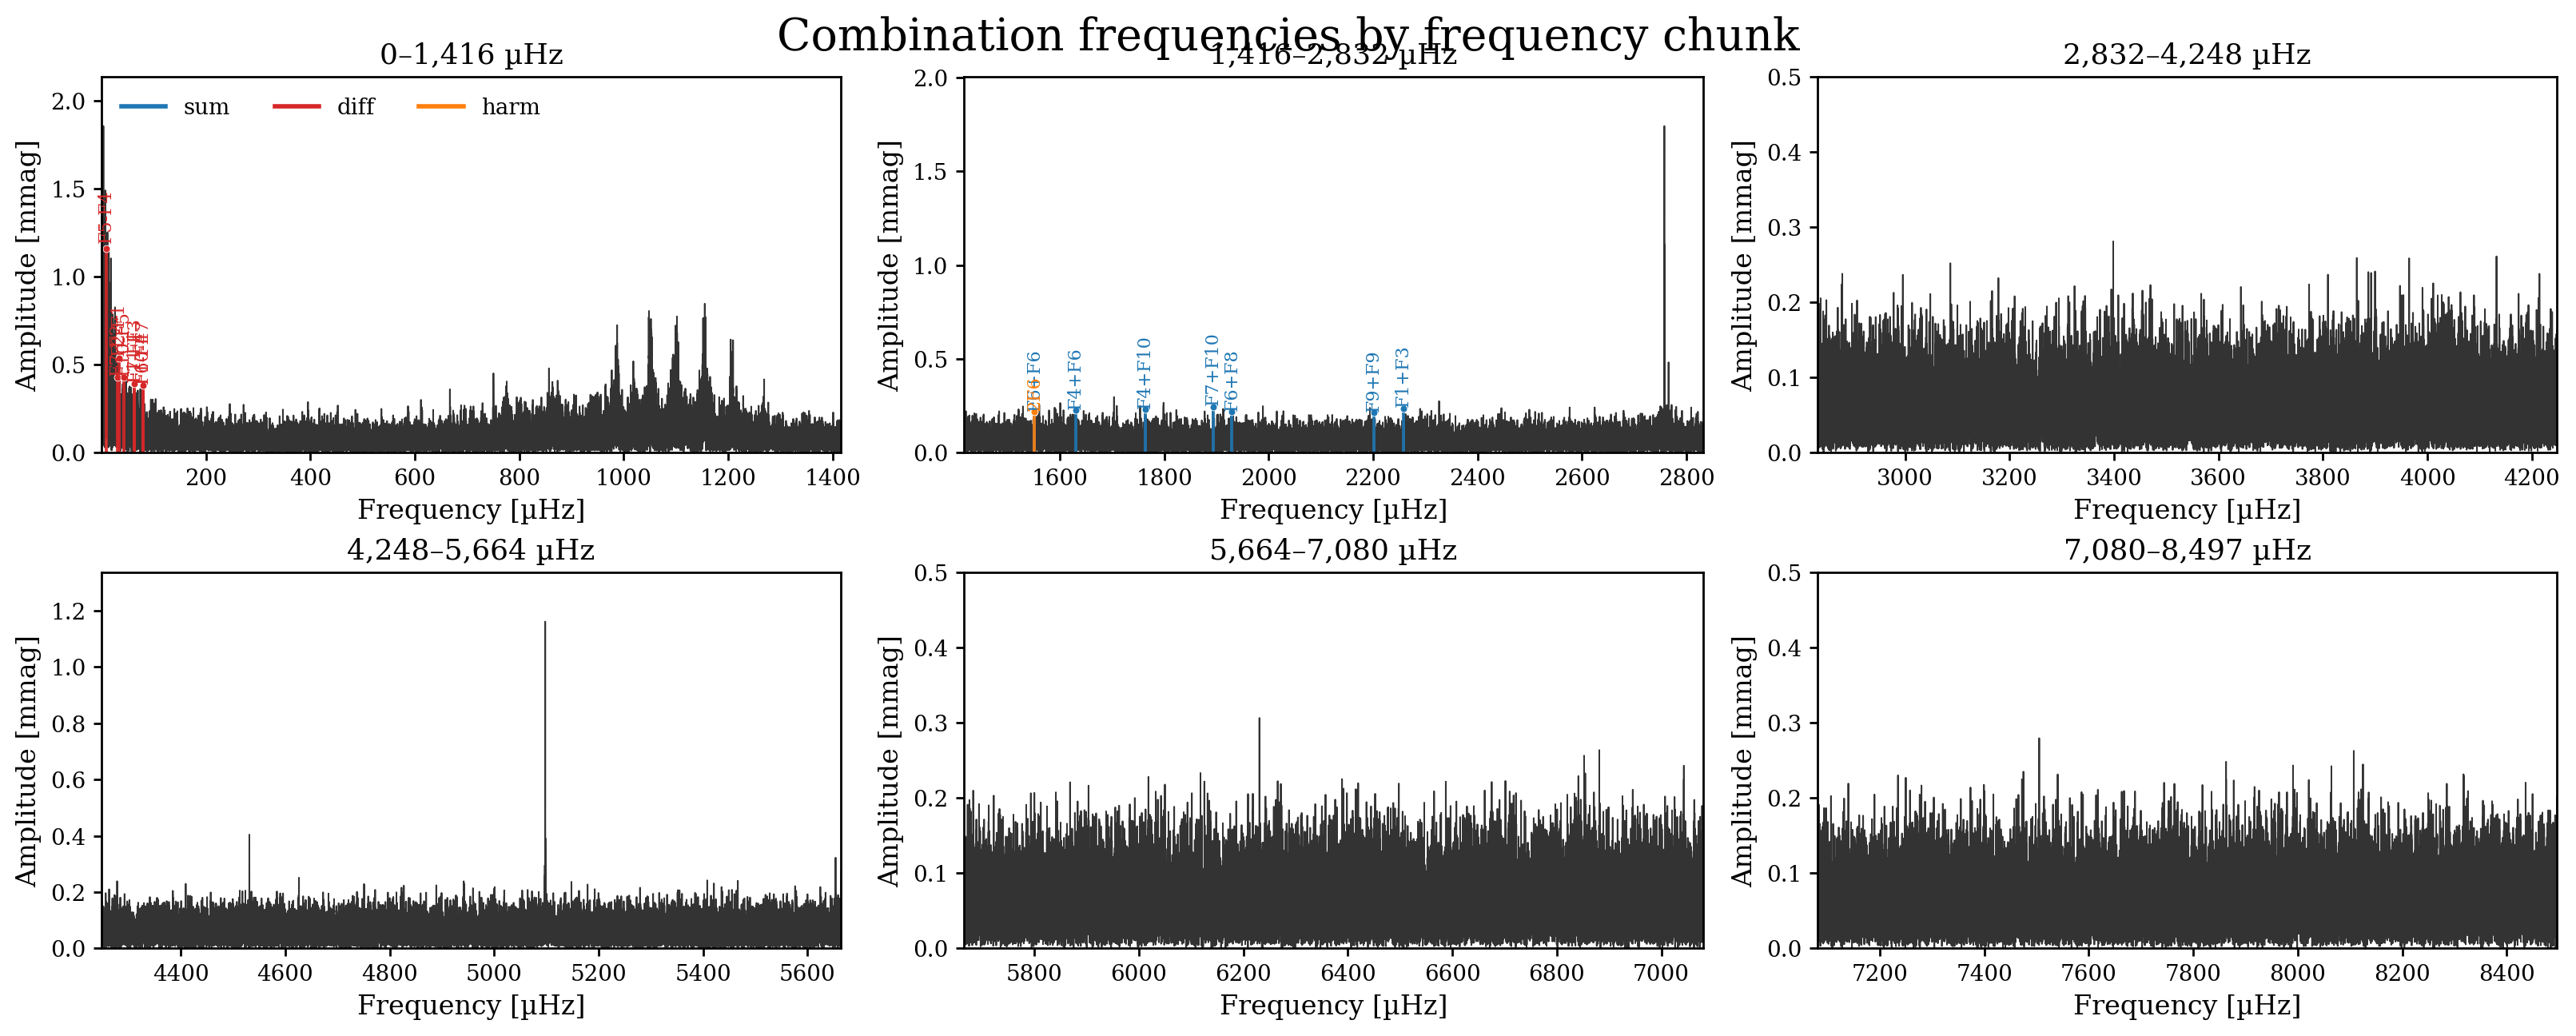

In [ ]:
# --- Yeates-style multi-panel plot of prominent combination peaks ---

pgA = lc.normalize(unit='ppm').to_periodogram(normalization='amplitude')
# amplitudes are in ppm; convert to mmag:
# small-signal: Δm [mag] ≈ -1.0857 * ΔF/F, so 1 ppm = 1e-6 in flux ≈ 1.0857e-6 mag = 0.0010857 mmag
amp_mmag = pgA.power.value * 0.0010857   # ppm → mmag
f_uHz     = pgA.frequency.to(u.uHz).value

noise_floor = uniform_filter1d(amp_mmag, size=2000)  # moving average baseline
amp_white = amp_mmag / np.maximum(noise_floor, np.percentile(noise_floor, 1))

# amp_mmag = amp_white

df_combo = globals().get("show", globals().get("combos_df", None))
if df_combo is None or len(df_combo) == 0:
    raise RuntimeError("No combination-frequency dataframe found (show/combos_df).")

# Minimal required columns + clean types
need = ["f_obs_uHz", "A_combo_mmag", "kind", "label"]
for c in need:
    if c not in df_combo.columns: 
        raise RuntimeError(f"Required column '{c}' missing from combos dataframe.")
df = df_combo.copy()
df["f_obs_uHz"]   = np.asarray(df["f_obs_uHz"], float)
df["A_combo_mmag"] = np.asarray(df["A_combo_mmag"], float)
df["kind"]        = df["kind"].astype(str)
df["label"]       = df["label"].astype(str)

# ---------- TUNABLE KNOBS ----------
AMP_MIN_MMAG      = 0.15     # show only combos above this amplitude at their bin
N_MAX_PER_CHUNK   = 8       # annotate at most this many labels in each panel
KIND_COLORS       = {"sum": "C0", "diff": "C3", "harm": "C1"}
TITLE             = "Combination frequencies by frequency chunk"
N_COLS            = 3        # 3x2 grid like Yeates Fig. 3.2
N_ROWS            = 2
# -----------------------------------

# choose chunk edges automatically across your plotted range
fmin, fmax = float(f_uHz.min()), float(f_uHz.max())
edges = np.linspace(fmin, fmax, N_COLS * N_ROWS + 1)

fig, axes = plt.subplots(
    nrows=N_ROWS, ncols=N_COLS, figsize=(16, 6.2),
    sharey=False, constrained_layout=True
)

axes = axes.ravel()
for i in range(N_COLS * N_ROWS):
    ax = axes[i]
    lo, hi = edges[i], edges[i+1]
    mwin = (f_uHz >= lo) & (f_uHz <= hi)

    # spectrum in grey
    ax.plot(f_uHz[mwin], amp_mmag[mwin], color="0.2", lw=0.7)
    ax.set_xlim(lo, hi)

    # autoscale y a bit above local max
    ymax = float(np.nanmax(amp_mmag[mwin])) if np.any(mwin) else 1.0
    ax.set_ylim(0.0, max(0.5, 1.15*ymax))

    # pick combos in the chunk, keep only prominent ones, then top-N by amplitude
    in_chunk = (df["f_obs_uHz"] >= lo) & (df["f_obs_uHz"] <= hi)
    sub = df.loc[in_chunk & (df["A_combo_mmag"] >= AMP_MIN_MMAG)].copy()
    if not sub.empty:
        sub = sub.sort_values("A_combo_mmag", ascending=False).head(N_MAX_PER_CHUNK)

        # draw "lollipop" markers with labels
        for _, r in sub.iterrows():
            c = KIND_COLORS.get(r["kind"].lower(), "k")
            ax.vlines(r["f_obs_uHz"], 0, r["A_combo_mmag"], color=c, lw=1.4, alpha=0.9)
            ax.plot([r["f_obs_uHz"]], [r["A_combo_mmag"]], "o", ms=3.2, color=c, mec="white", mew=0.3)
            ax.text(r["f_obs_uHz"], r["A_combo_mmag"] * 1.03, r["label"],
                    color=c, rotation=90, ha="center", va="bottom", fontsize=8)

    # tidy ticks/titles
    ax.set_xlabel("Frequency [µHz]")
    ax.set_ylabel("Amplitude [mmag]")
    ax.set_title(f"{lo:,.0f}–{hi:,.0f} µHz", fontsize=13)

# add a single legend for kinds
kinds_present = [k for k in ["sum","diff","harm"] if any(df["kind"].str.lower()==k)]
handles = [Line2D([0],[0], color=KIND_COLORS[k], lw=2, label=k) for k in kinds_present]
if handles:
    axes[0].legend(handles=handles, frameon=False, ncol=len(handles), loc="upper left")

fig.suptitle(TITLE, fontsize=20, y=1.02)
plt.show()


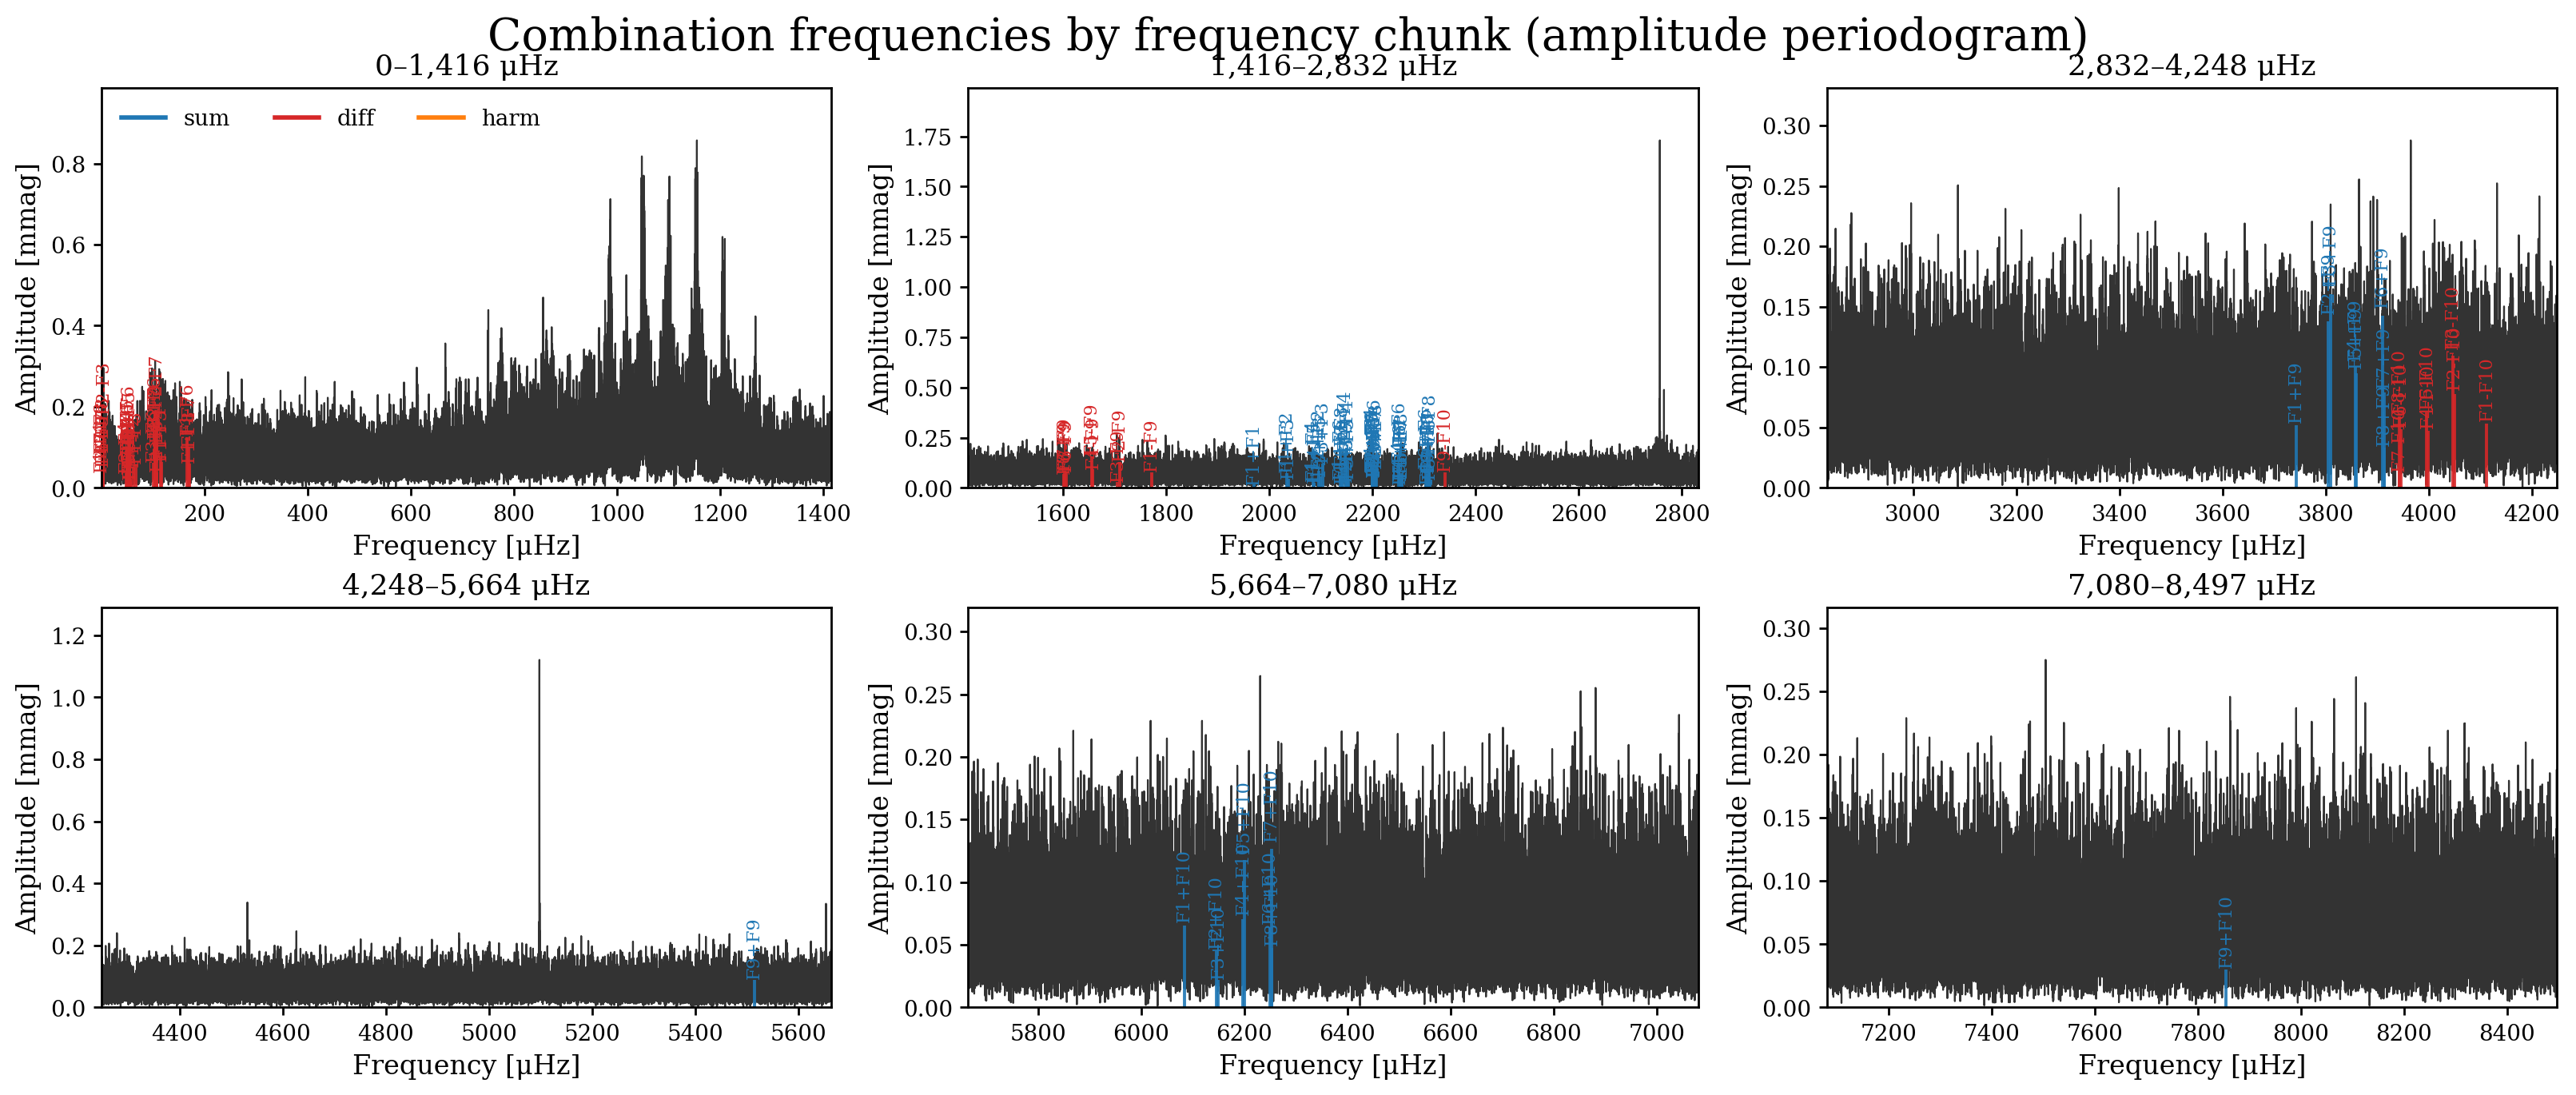

In [ ]:
# ==========================================================
# 1. Build amplitude periodogram (smooth, oversampled)
# ==========================================================
lc1 = lc.remove_nans().remove_outliers(sigma=5).flatten(window_length=301, polyorder=2)
pgA = lc1.normalize(unit='ppm').to_periodogram(
    method='lombscargle', oversample_factor=8, normalization='amplitude')
f_uHz = pgA.frequency.to(u.uHz).value
amp_mmag = pgA.power.value * 0.0010857
Aplot = savgol_filter(amp_mmag, 9, 3)   # light smoothing for readability

# ==========================================================
# 2. Fit Lorentzians to strongest peaks (main pulsation modes)
# ==========================================================
def lorentz(fr, H, nu0, gamma): return H / (1 + ((fr - nu0) / gamma)**2)
def lorentz_sum(fr, C, *params):
    tot = C * np.ones_like(fr)
    for H, nu, g in np.array(params).reshape(-1, 3):
        tot += lorentz(fr, H, nu, g)
    return tot

# find main peaks
pk, prop = find_peaks(Aplot, prominence=np.percentile(Aplot, 97))
sel = np.argsort(prop["prominences"])[::-1][:10]  # top 10
fpk, hpk = f_uHz[pk][sel], Aplot[pk][sel]
wpk = peak_widths(Aplot, pk[sel], rel_height=0.5)[0] * np.median(np.diff(f_uHz))

# initial parameters for Lorentzian sum fit
theta0, lo, hi = [np.percentile(Aplot, 5)], [0], [np.inf]
for H, nu, g in zip(hpk, fpk, wpk):
    theta0 += [H, nu, max(g / 2, 1.0)]
    lo += [0, nu - 8, 0.2]
    hi += [np.inf, nu + 8, 10]
popt, _ = curve_fit(lorentz_sum, f_uHz, Aplot, p0=theta0, bounds=(lo, hi), maxfev=200000)
pars = np.array(popt[1:]).reshape(-1, 3)
fit_tab = pd.DataFrame(dict(H=pars[:, 0], nu=pars[:, 1], g=pars[:, 2])).sort_values("nu").reset_index(drop=True)
parents = fit_tab.nu.values

# ==========================================================
# 3. Predict combination frequencies (sum, diff, harmonic)
# ==========================================================
tol = 1.0  # matching tolerance (μHz)
combos = []
for i, a in enumerate(parents):
    for j, b in enumerate(parents[i:], start=i):
        combos += [(a + b, "sum", i + 1, j + 1),
                   (abs(a - b), "diff", i + 1, j + 1)]
    combos += [(2 * a, "harm", i + 1, i + 1)]
combos_df = pd.DataFrame(combos, columns=["f_pred", "kind", "i", "j"])
combos_df["label"] = combos_df.apply(
    lambda r: f"F{r.i}+F{r.j}" if r.kind == "sum" else
              f"F{r.i}-F{r.j}" if r.kind == "diff" else
              f"2F{r.i}", axis=1)

# match to observed peaks
f_array = np.asarray(f_uHz)
combos_df["f_obs"] = np.nan
for k, f_pred in enumerate(combos_df.f_pred):
    d = np.abs(f_array - f_pred)
    if np.min(d) <= tol:
        combos_df.loc[k, "f_obs"] = f_array[np.argmin(d)]
combos_df.dropna(inplace=True)
combos_df = combos_df.drop_duplicates(subset=["f_obs"]).reset_index(drop=True)

# ==========================================================
# 4. Plot Yeates-style multi-panel figure
# ==========================================================
N_COLS, N_ROWS = 3, 2
edges = np.linspace(f_uHz.min(), f_uHz.max(), N_COLS * N_ROWS + 1)
fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(16, 6.5), constrained_layout=True)
axes = axes.ravel()
KCOL = {"sum": "C0", "diff": "C3", "harm": "C1"}

for i in range(N_COLS * N_ROWS):
    ax = axes[i]
    lo, hi = edges[i], edges[i + 1]
    m = (f_uHz >= lo) & (f_uHz <= hi)
    ax.plot(f_uHz[m], Aplot[m], color="0.2", lw=0.8)
    ymax = float(np.nanmax(Aplot[m])) if np.any(m) else 1.0
    ax.set_ylim(0, 1.15 * ymax)
    ax.set_xlim(lo, hi)
    ax.set_xlabel("Frequency [μHz]")
    ax.set_ylabel("Amplitude [mmag]")
    ax.set_title(f"{lo:,.0f}–{hi:,.0f} μHz", fontsize=13)

    # mark combination frequencies in this chunk
    sub = combos_df[(combos_df.f_obs >= lo) & (combos_df.f_obs <= hi)]
    for _, r in sub.iterrows():
        c = KCOL.get(r.kind, "k")
        amp = Aplot[np.argmin(np.abs(f_uHz - r.f_obs))]
        ax.vlines(r.f_obs, 0, amp, color=c, lw=1.4, alpha=0.9)
        ax.text(r.f_obs, amp * 1.05, r.label, color=c,
                rotation=90, ha="center", va="bottom", fontsize=8)

handles = [Line2D([0], [0], color=KCOL[k], lw=2, label=k) for k in KCOL]
axes[0].legend(handles=handles, frameon=False, ncol=3, loc="upper left")
fig.suptitle("Combination frequencies by frequency chunk (amplitude periodogram)", fontsize=20, y=1.03)
plt.show()